## Лекции:
* [1 Лекция - Интро](#l1)
* [2 Лекция - DataFrame API 1](#l2)
* [3 Лекция - DataFrame API 2](#l3) 
* [4 Лекция - Оптимизация запросов](#l4)
* [5 Лекция - RDD](#l5)
* [6 Лекция - Deploy & Docker (только в папке)](#l6)
* [7 Лекция - Airflow-1 (только в папке)](#l7)
* [8 Лекция - Airflow-2 (только в папке)](#l8)

## Домашние задания:
* [1 Лекция - Интро](#uhw1)
* [2 Лекция - DataFrame API 1](#uhw2)
* [3 Лекция - DataFrame API 2](#uhw3) 
* [4 Лекция - Оптимизация запросов](#uhw4)
* [5 Лекция - RDD](#uhw5)

## Домашние задания (готовые):
* [1 Лекция - Интро](#hw1)
* [2 Лекция - DataFrame API 1](#hw2)
* [3 Лекция - DataFrame API 2](#hw3) 
* [4 Лекция - Оптимизация запросов](#hw4)
* [5 Лекция - RDD](#hw5)

## Дополнительно
* [Window functions](#wf1)
* [UDF](#udf1)
* [Добавление соли](#salt1)
* [Планы выполнения задач](#plan1)
* [Оптимизация соединений и группировок](#plan2)
* [PAIR RDD Transformations](#rdd1)


## 1 Лекция - Интро <a class="anchor" id="l1"></a>

###  Загрузка данных в локальную файловую систему

In [ ]:
%sh

cd data
rm -rf data_nov.csv.zip
curl http://37.139.43.86/data-nov > data_nov.csv


ls -lh ./

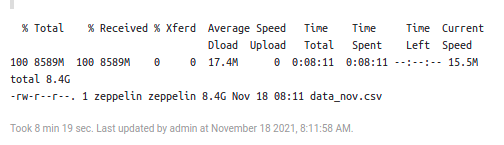

### Загрузка данных на hdfs

In [ ]:
%sh

hdfs dfs -mkdir data

hdfs dfs -put data/data_nov.csv data

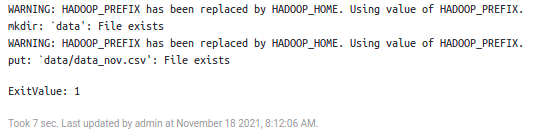

In [ ]:
%sh

hdfs dfs -du -h data

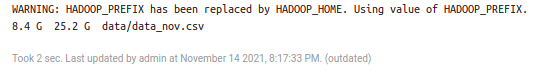

In [ ]:
%pyspark

spark.sql("show databases").show()

# тут почему-то exception, но что поделать

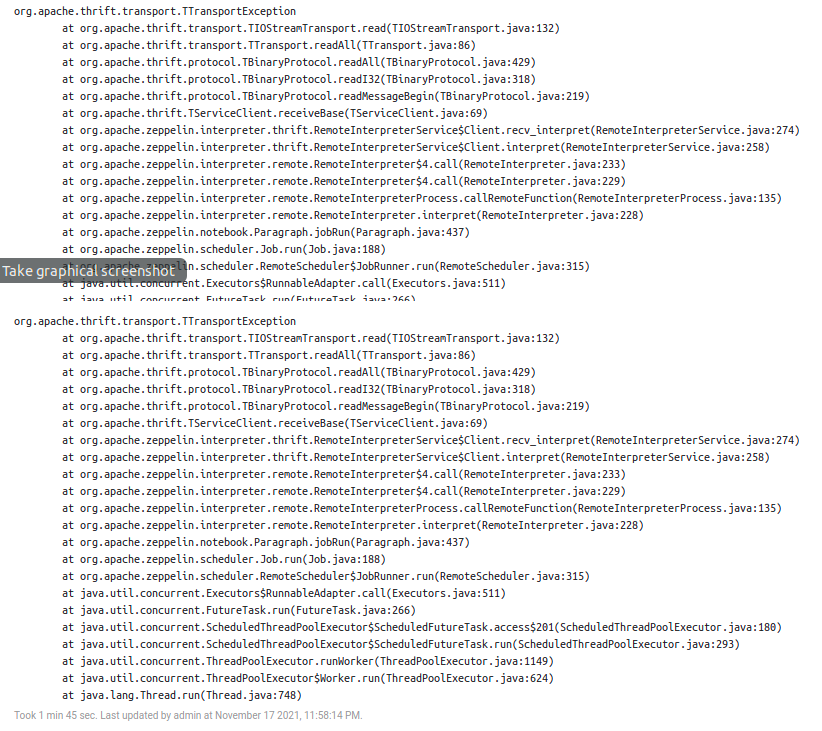

### Чтение данных из csv и сохранение в parquet формат

In [ ]:
%pyspark

# schema = "event_time timestamp, event_type string, product_id long, category_id long, category_code string, brand string, price float, user_id long, user_session string"

df = spark.read \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .csv("data/data_nov.csv")

df.printSchema()

df \
.write.mode("overwrite") \
.format("parquet") \
.save("data/data_nov.parquet")

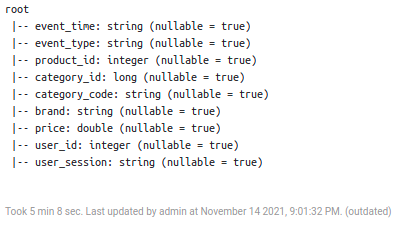

In [ ]:
%pyspark
df.show()

# тут должны показываться данные как в Python\pandas df.head()

In [ ]:
%sh

hdfs dfs -du -h data

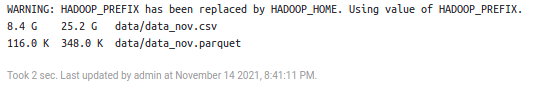

In [ ]:
%sh

hdfs dfs -du -h data/data_nov.parquet

# показывает куски паркета

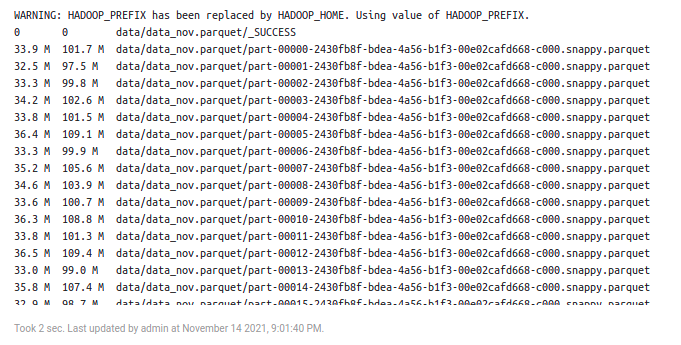

In [ ]:
%pyspark

spark.read.parquet("data/data_nov.parquet").coalesce(1).write.mode("overwrite").parquet("data/data_nov_coalesce.parquet")

# читает паркет и перезаписывает его в 1 кусок

In [ ]:
%sh
hdfs dfs -du -h data/data_nov_coalesce.parquet

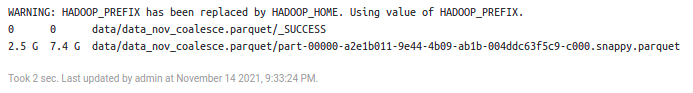

In [ ]:
%pyspark

events_df = spark.read.parquet("data/data_nov_coalesce.parquet")

events_df.printSchema()
events_df.show(100)

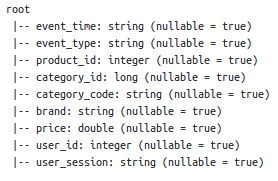

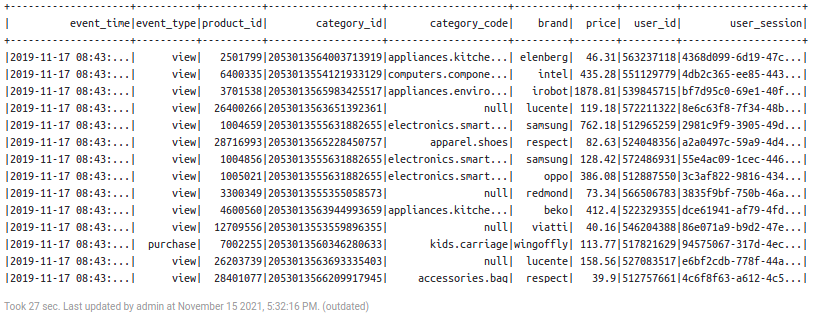

In [ ]:
%pyspark

events_df.select(f.min("event_time"), f.max("event_time")).show(truncate=False)

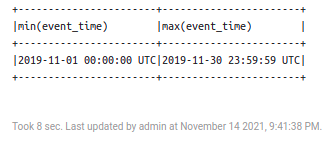

In [ ]:
%pyspark

events_df.where("brand = 'intel'").show()

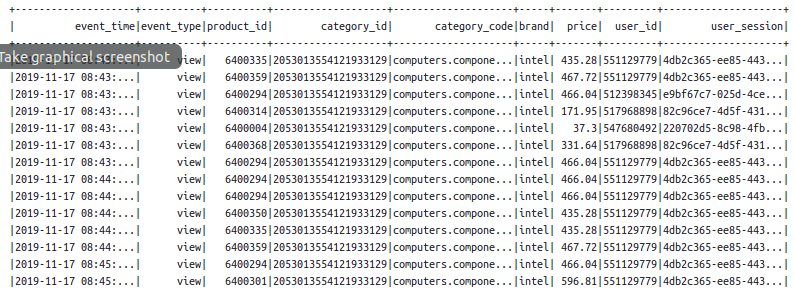

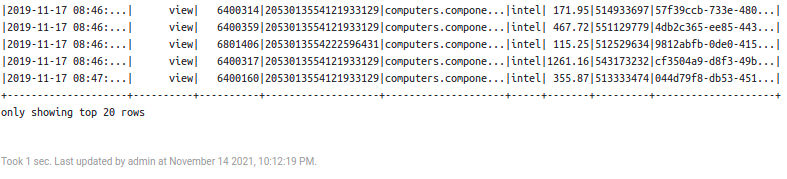

### Сохранение в hive metastore

In [ ]:
%pyspark

spark.sql("create database src_data")

events_df.write.saveAsTable("src_data.events")

In [ ]:
%sh

hdfs dfs -du -h /apps/hive/warehouse

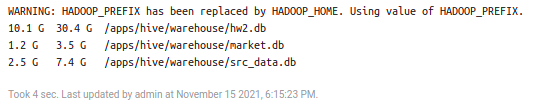

In [ ]:
%sh

hdfs dfs -du -h /apps/hive/warehouse/src_data.db/events

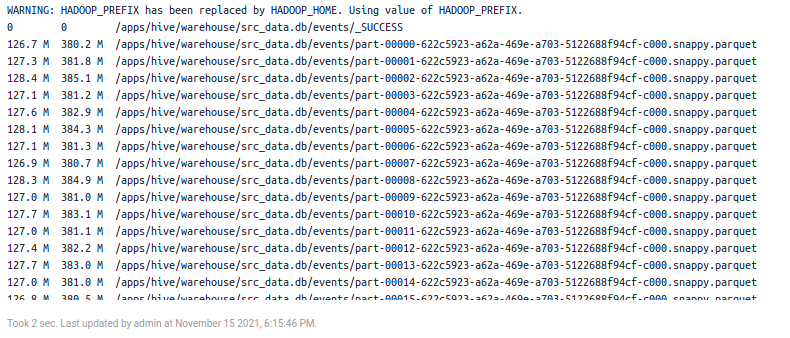

### Добавление колонки + сохранение по партициям

In [ ]:
%pyspark
import pyspark.sql.functions as f

spark.sql("create database market")

spark.table("src_data.events") \
.withColumn("date", f.to_date("event_time")) \
.write.partitionBy("date").saveAsTable("market.events")

In [ ]:
%sh


hdfs dfs -du -h /apps/hive/warehouse/market.db/events

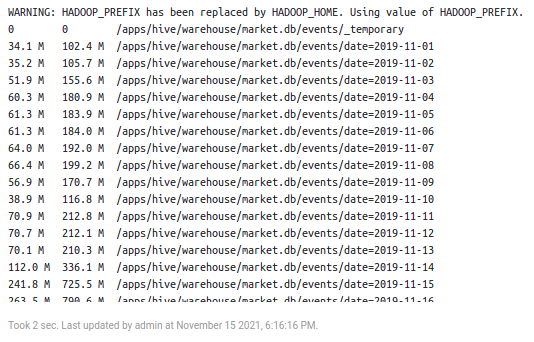

In [ ]:
%sh

hdfs dfs -du -h /apps/hive/warehouse/market.db/events/date=2019-11-03

# чтение по партициям

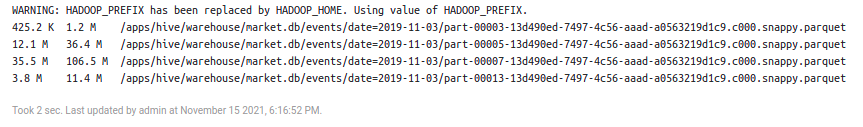

### Группировка

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df \
    .groupBy("event_type") \
    .agg(
        f.count("*").alias("count")
        ) \
    .orderBy(f.col("count").desc()) \
    .show(truncate=False)


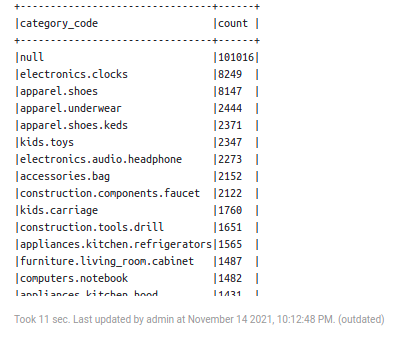

## 1 Лекция - Интро HOMEWORK <a class="anchor" id="uhw1"></a>

In [ ]:
# Вывести топ категорий по количеству просмотров товаров за всё время

%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events")
# events_df.printSchema()
print(events_df.head())
df = events_df.show(20)

In [ ]:
# Построить гистограмму распределения цен на проданные товары за 10 ноября 2019 года

%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events")

z.show(
    events_df \
    # запрос здесь: фильтр по дням, добавление бина, группировка по ним
)


## 2 Лекция - DataFrame API 1 <a class="anchor" id="l2"></a>

### Задание схемы DataFrame

In [ ]:
%pyspark

schema = "`Id` INT, `First` STRING, `Last` STRING, `Url` STRING, `Published` STRING, `Hits` INT, `Campaigns` ARRAY<STRING>"

# Create our static data
data = [
    [1, "Jules", "Damji", "https://tinyurl.1", "1/4/2016", 4535, ["twitter","LinkedIn"]],
    [2, "Brooke","Wenig", "https://tinyurl.2", "5/5/2018", 8908, ["twitter", "LinkedIn"]],
    [3, "Denny", "Lee", "https://tinyurl.3", "6/7/2019", 7659, ["web", "twitter", "FB", "LinkedIn"]],
    [4, "Tathagata", "Das", "https://tinyurl.4", "5/12/2018", 10568, ["twitter", "FB"]],
    [5, "Matei","Zaharia", "https://tinyurl.5", "5/14/2014", 40578, ["web", "twitter", "FB", "LinkedIn"]],
    [6, "Reynold", "Xin", "https://tinyurl.6", "3/2/2015", 25568, ["twitter", "LinkedIn"]]
]

# Create a DataFrame using the schema defined above
blogs_df = spark.createDataFrame(data=data, schema=schema)
# Show the DataFrame; it should reflect our table above
blogs_df.show()
# Print the schema used by Spark to process the DataFrame
print(blogs_df.printSchema())


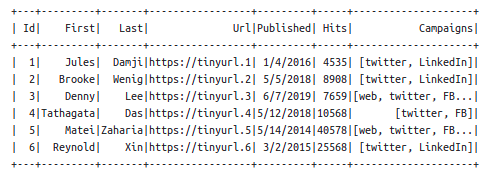

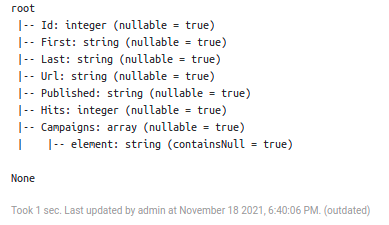

In [ ]:
%pyspark

from pyspark.sql.functions import col, sum

blogs_df\
.selectExpr("*" , "concat(first, ' ', last) full_name")\
.agg(sum(col("Hits")).alias("Hits"))\
.show()

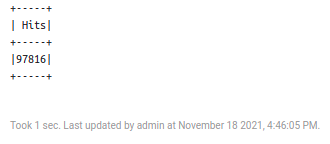

In [ ]:
%pyspark

events_df = spark.table("market.events")

grouped = events_df.groupBy("brand").agg(f.count("*")) 

grouped.show()

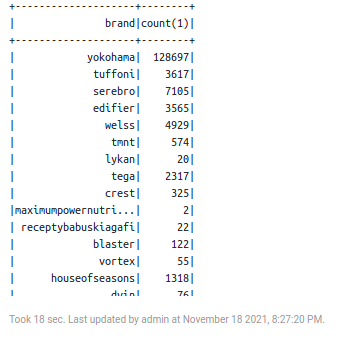

In [ ]:
%pyspark

from pyspark.sql.functions import expr

blogs_df\
.where("hits > 10000")\
.show()

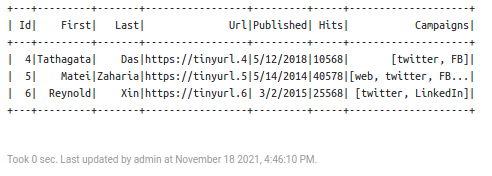

In [ ]:
sc.applicationId

# res9: String = application_XXXXXXXXXXXx_YYYY

In [ ]:
%sh

curl http://37.139.43.86/sf-fire-calls > sf-fire-calls.csv

hdfs dfs -put sf-fire-calls.csv data

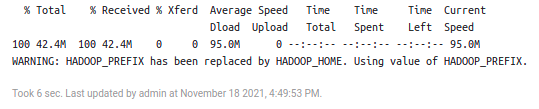

In [ ]:
%sparkLocal.pyspark

spark.read.option("header", True).option("inferSchema", True).csv("data/sf-fire-calls.csv") \
.write.parquet("data/sf-fire-calls.parquet")

In [ ]:
%pyspark

fireDF = spark.read.option("header", True).load("data/sf-fire-calls.parquet")
fireDF.printSchema()
fireDF.show(100, False)

# данные не влезают в экран, вывел кусок для примера

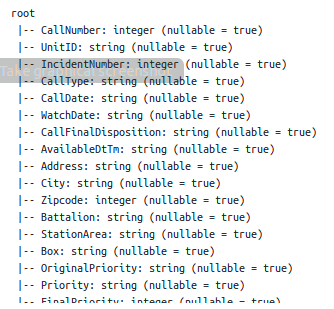

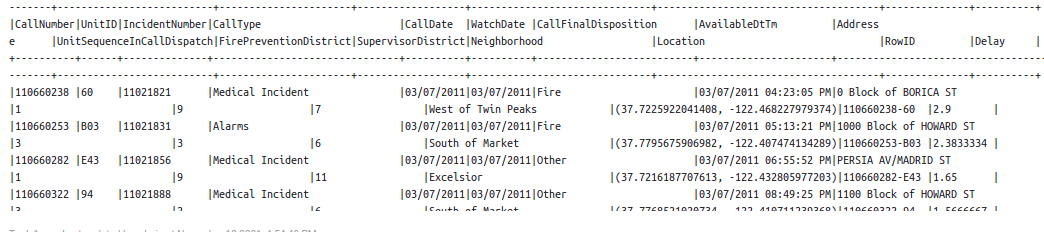

### What were all the different types of fire calls in 2018?

In [ ]:
%pyspark
import pyspark.sql.functions as f

fireDF \
.withColumn("CallDate", 
    f.to_timestamp(f.col("CallDate"), 'dd/MM/yyyy'))\
.withColumn("CallYear", f.year("CallDate"))\
.where("CallYear = '2018'") \
.select("CallType")\
.distinct()\
.show(1000, False)

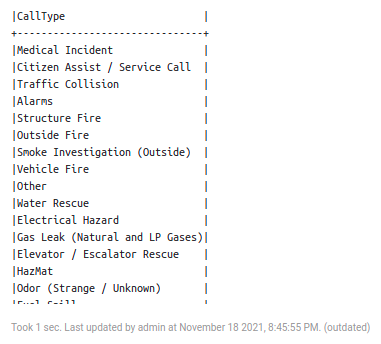

### What months within the year 2018 saw the highest number of fire calls?

In [ ]:
%pyspark

fireDF\
.withColumn("CallDate", f.to_timestamp(f.col("CallDate"), 'dd/MM/yyyy'))\
.withColumn("CallMonth", f.month("CallDate"))\
.withColumn("CallYear", f.year("CallDate"))\
.where("CallYear = '2018'") \
.groupBy("CallMonth")\
.agg(
    f.countDistinct("callNumber").alias("call_count")
    )\
.orderBy("call_count", ascending=False)\
.show()

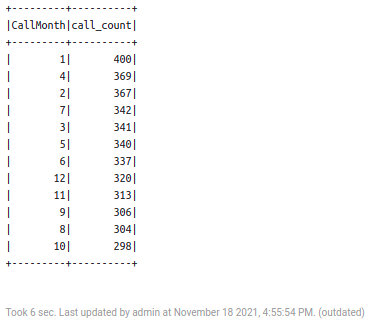

### Which neighborhood in San Francisco generated the most fire calls in 2018?

In [ ]:
%pyspark

(fireDF
.groupBy("Neighborhood")
.agg(countDistinct("callNumber").alias("call_count"))
.orderBy("call_count", ascending=False)
.show(1000, False))

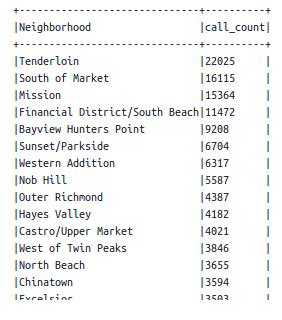

### Which neighborhoods had the worst response times to fire calls in 2018?

In [ ]:
%pyspark

fireDF\
.where("lower(CallType) like '%fire%'")\
.select("Neighborhood", "delay", "callType")\
.orderBy("delay", ascending=False)\
.show()

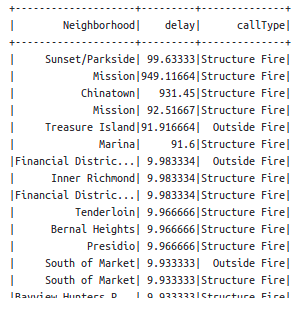

### Which week in the year in 2018 had the most fire calls?

In [ ]:
%pyspark

fireDF\
.where("lower(CallType) like '%fire%'")\
.withColumn("CallDate", f.to_timestamp(f.col("CallDate"), 'dd/MM/yyyy'))\
.withColumn("CallWeek", f.weekofyear("CallDate"))\
.withColumn("CallYear", f.year("CallDate"))\
.where("CallYear = '2018'") \
.groupBy("CallYear", "CallWeek")\
.agg(
    f.countDistinct("callNumber").alias("call_count")
    )\
.orderBy("call_count", ascending=False)\
.show()


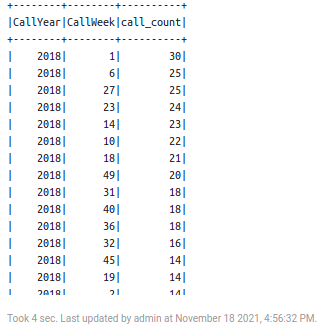

### Create UDF

In [ ]:
%pyspark

df1 = spark.createDataFrame([
    (1, "andy", 20, "USA"), 
    (2, "jeff", 23, "China"), 
    (3, "james", 18, "USA")]) \
.toDF("id", "name", "age", "country")

# Create udf create python lambda
from pyspark.sql.functions import udf
udf1 = udf(lambda e: e.upper())
df2 = df1.select(udf1(df1["name"]))
df2.show()

# UDF could also be used in filter, in this case the return type must be Boolean
# We can also use annotation to create udf
from pyspark.sql.types import *

@udf(returnType=BooleanType())
def udf2(e):
    if e >= 20:
        return True;
    else:
        return False

df3 = df1.filter(udf2(df1["age"]))
df3.show()

# UDF could also accept more than 1 argument.
udf3 = udf(lambda e1, e2: e1 + "_" + e2)
df4 = df1.select(udf3(df1["name"], df1["country"]).alias("name_country"))
df4.show()

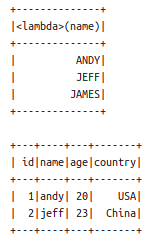

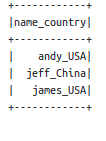

### Join on Single Field

In [ ]:
%pyspark

df1 = spark.createDataFrame([
    (1, "andy", 20, 1), 
    (2, "jeff", 23, 2), 
    (3, "james", 18, 3)])
    .toDF("id", "name", "age", "c_id")
    
df1.show()

df2 = spark.createDataFrame([(1, "USA"), (2, "China")]).toDF("c_id", "c_name")
df2.show()

# You can just specify the key name if join on the same key
df3 = df1.join(df2, on=["c_id"], how="inner")
df3.show()

# Or you can specify the join condition expclitly in case the key is different between tables
df4 = df1.join(df2, df1["c_id"] == df2["c_id"] )
df4.show()

# You can specify the join type afte the join condition, by default it is inner join
df5 = df1.join(df2, df1["c_id"] == df2["c_id"], "left_outer")
df5.show()

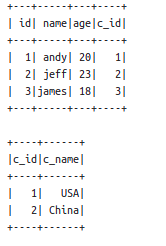

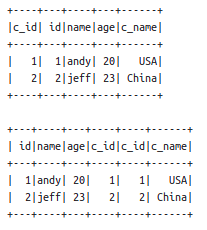

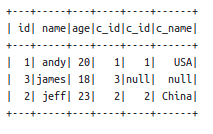

### Join on Multiple Fields

In [ ]:
%pyspark

df1 = spark.createDataFrame([("andy", 20, 1, 1), ("jeff", 23, 1, 2), ("james", 12, 2, 2)]).toDF("name", "age", "key_1", "key_2")
df1.show()

df2 = spark.createDataFrame([(1, 1, "USA"), (2, 2, "China")]).toDF("key_1", "key_2", "country")
df2.show()

# Join on 2 fields: key_1, key_2

# You can pass a list of field name if the join field names are the same in both tables
df3 = df1.join(df2, ["key_1", "key_2"])
df3.show()

# Or you can specify the join condition expclitly in case when the join fields name is differetnt in the two tables
df4 = df1.join(df2, (df1["key_1"] == df2["key_1"]) & (df1["key_2"] == df2["key_2"]))
df4.show()


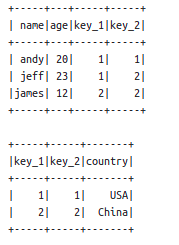

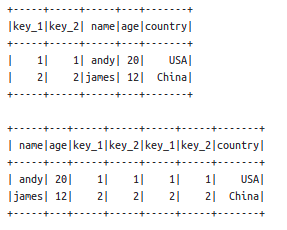

### spark.sql directly


In [ ]:
%pyspark

df1 = spark.createDataFrame([
        (1, "andy", 20, "USA"), 
        (2, "jeff", 23, "China"), 
        (3, "james", 18, "USA")]) \
    .toDF("id", "name", "age", "country")
    
df1.createOrReplaceTempView("people")

df2 = spark.
("select name, age from people")
df2.show()

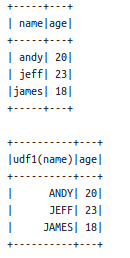

## 2 Лекция - DataFrame API 1 HOMEWORK <a class="anchor" id="uhw2"></a>

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events")

events_df.show()

events_df.printSchema()

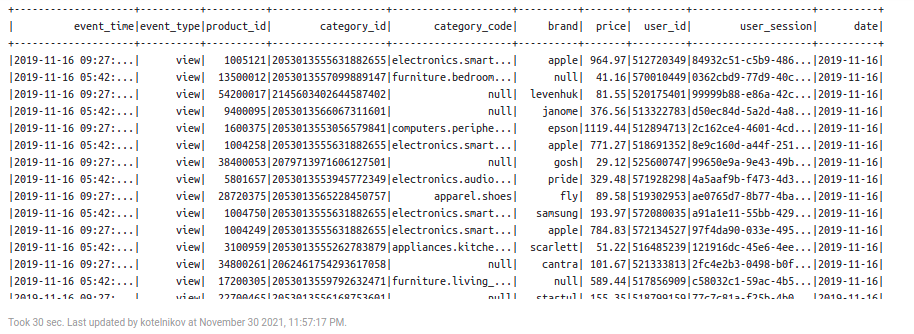

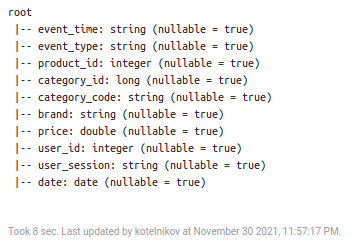

In [ ]:
1 - Посчитать количество продаж отдельно бренда apple и остальных

In [ ]:
2 - Построить почасовой график продаж и прибыли за всё время

In [ ]:
%pyspark

# to_timestamp, date_trunc
z.show(
    events_df
    
    )

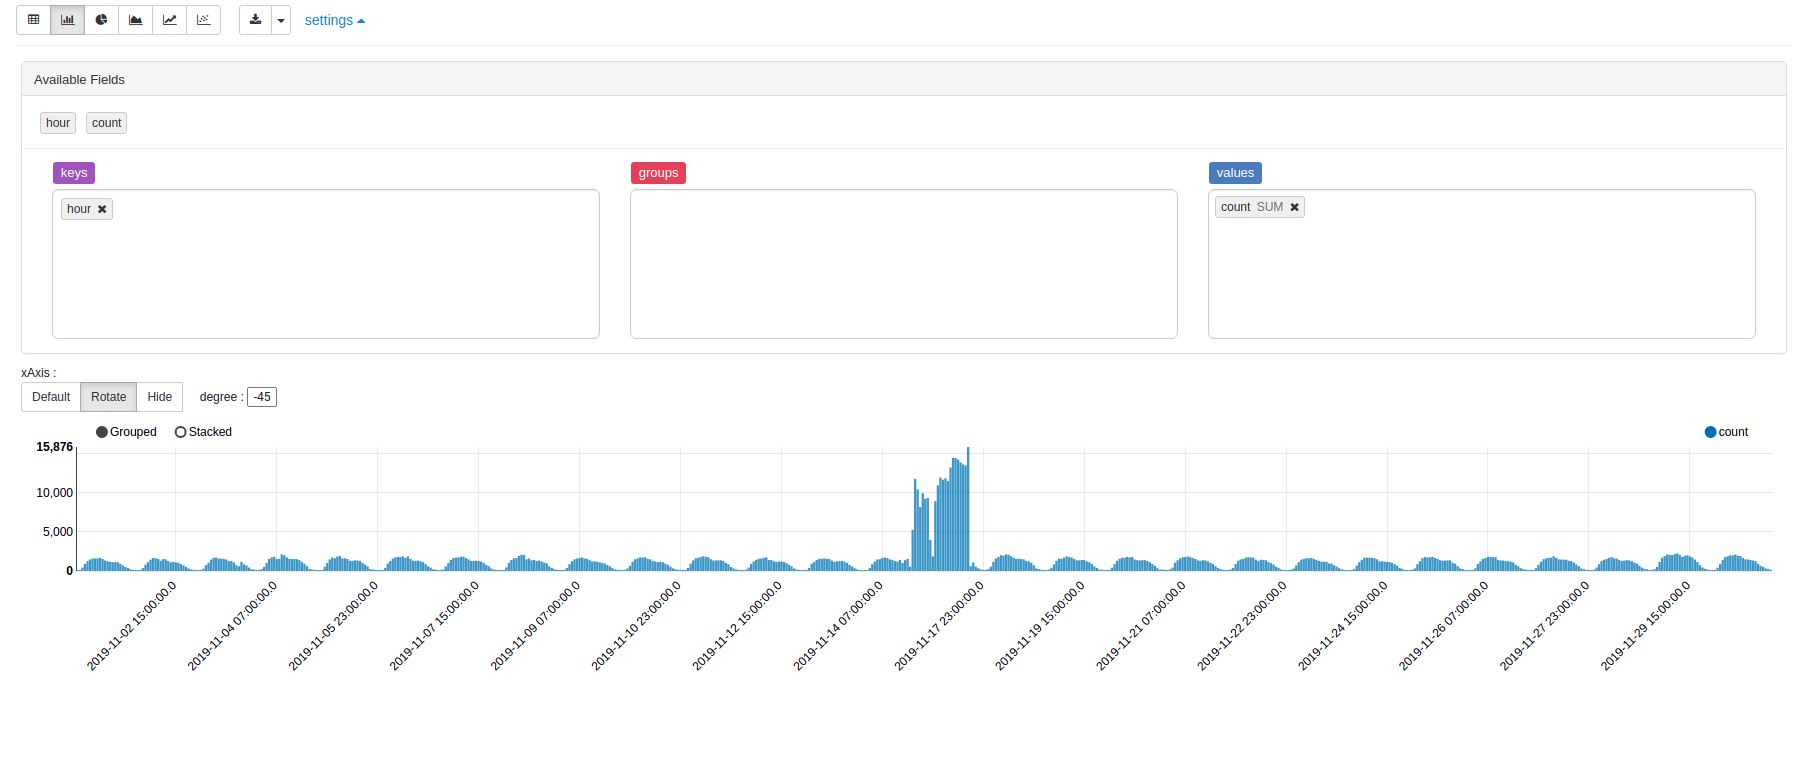

In [ ]:
3 - Построить среднесуточный график продаж

In [ ]:
%pyspark

# to_timestamp, date_trunc, hour
z.show(
    events_df
    
)

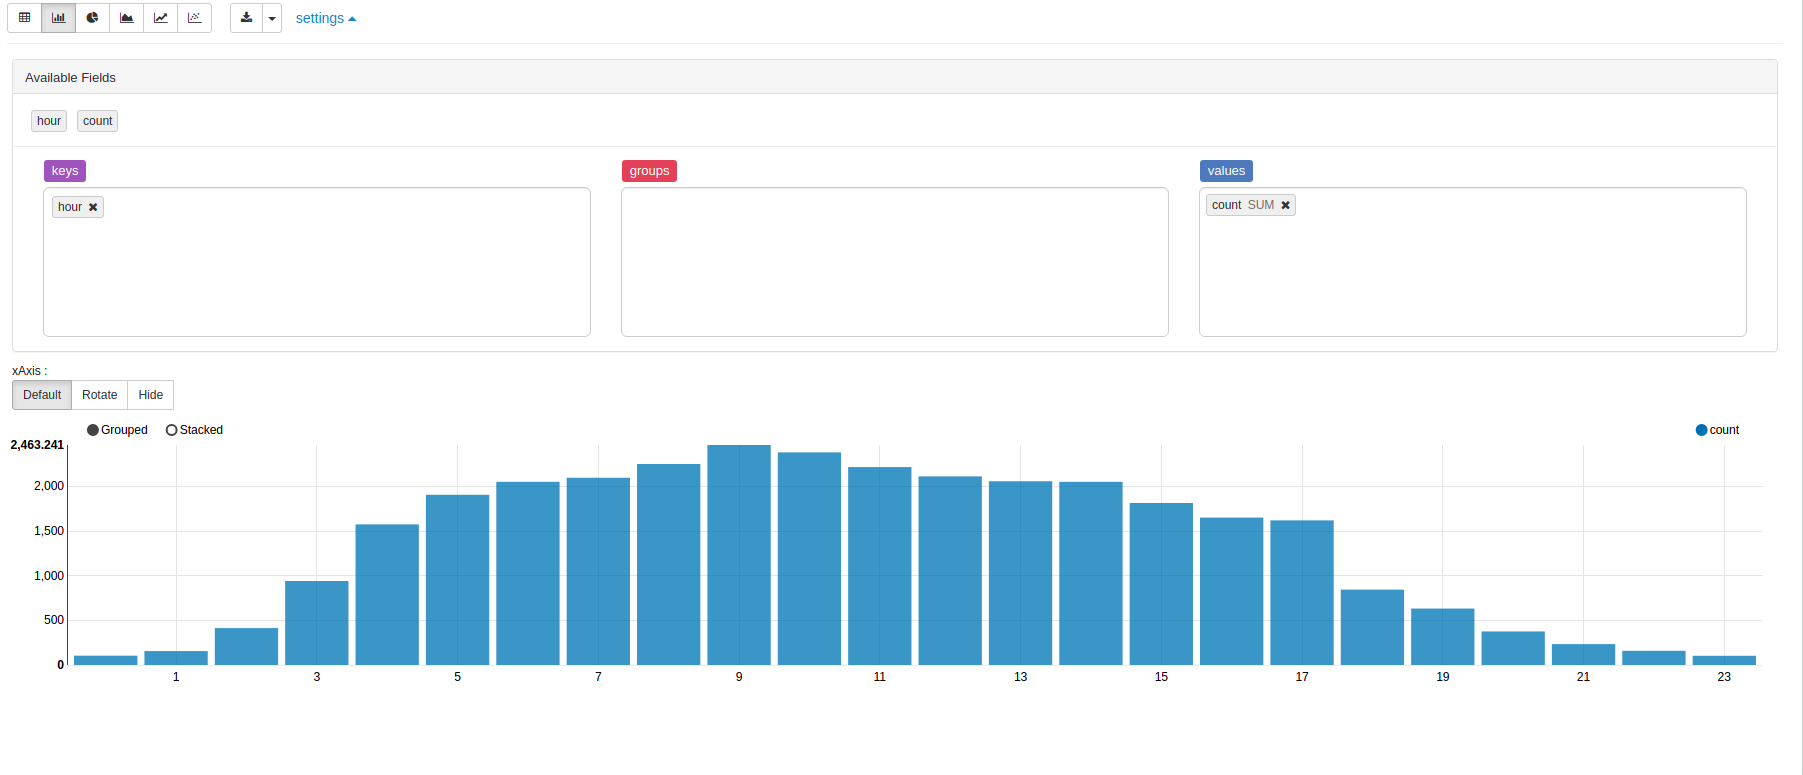

In [ ]:
4 - Построить среднесуточный график просмотров

In [ ]:
%pyspark

z.show(
    events_df
)

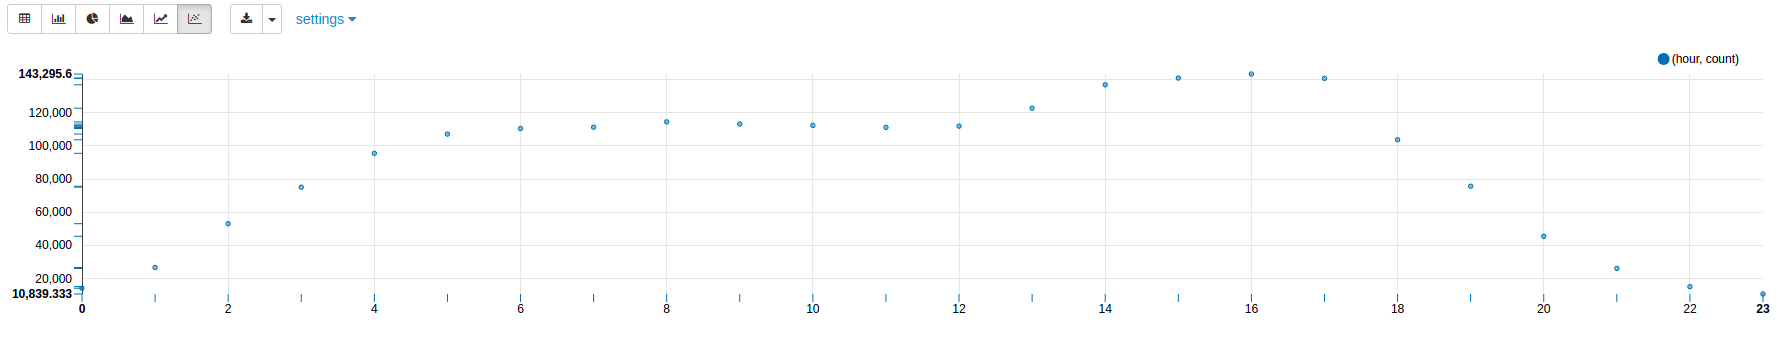

## 3 Лекция - DataFrame API 2 <a class="anchor" id="l3"></a>

### Union

In [ ]:
%pyspark

from pyspark.sql import SparkSession


simpleData = [
    ("James","Sales","NY",90000,34,10000), 
    ("Michael","Sales","NY",86000,56,20000), 
    ("Robert","Sales","CA",81000,30,23000), 
    ("Maria","Finance","CA",90000,24,23000) 
  ]

columns= ["employee_name","department","state","salary","age","bonus"]
df = spark.createDataFrame(data = simpleData, schema = columns)
df.printSchema()
df.show(truncate=False)

simpleData2 = [
    ("James","Sales","NY",90000,34,10000), 
    ("Maria","Finance","CA",90000,24,23000), 
    ("Jen","Finance","NY",79000,53,15000), 
    ("Jeff","Marketing","CA",80000,25,18000), 
    ("Kumar","Marketing","NY",91000,50,21000) 
  ]
columns2= ["employee_name", "department", "state", "salary", "age", "bonus"]

df2 = spark.createDataFrame(data=simpleData2, schema = columns2)

df2.printSchema()
df2.show(truncate=False)

unionDF = df.union(df2)
unionDF.show(truncate=False)
disDF = df.union(df2).distinct()
disDF.show(truncate=False)

unionAllDF = df.unionAll(df2)
unionAllDF.show(truncate=False)

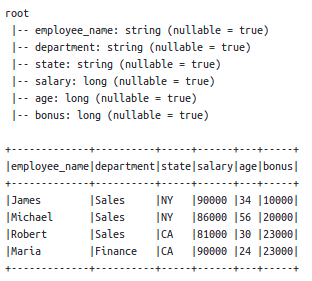

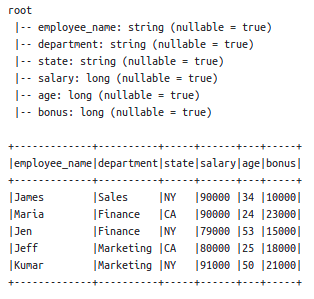

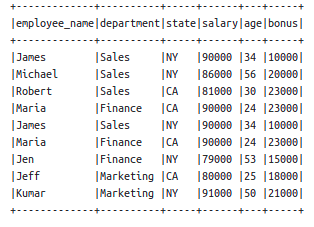

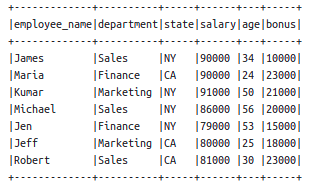

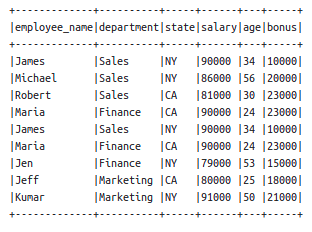

### Union. Различный порядок колонок

In [ ]:
%pyspark
simpleData3 = [
    ("Sales","Jones","NY",90000,34,10000), 
    ("Finance","Maria","CA",90000,24,23000), 
    ("Finance","Jen","NY",79000,53,15000), 
  ]
columns3= ["department", "employee_name","state","salary","age","bonus"]

df3 = spark.createDataFrame(data = simpleData3, schema = columns3)

print("df:")
df.show()
print("df3:")
df3.show()

unionDF = df.union(df3)
unionDF.show(truncate=False)

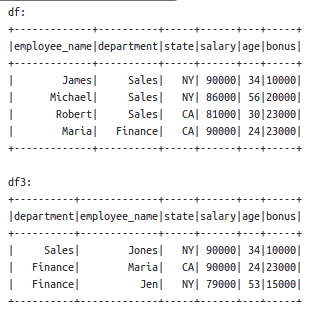

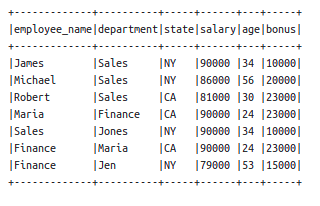

### Safe union

In [ ]:
%pyspark

df.union(
    df3.select(df.columns)
).show(truncate=False)


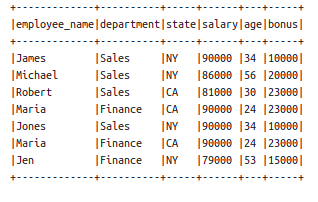

### Regexp

In [ ]:
%pyspark

from pyspark.sql.functions import regexp_replace, col

habrData\
.select("link")\
.withColumn("company_id", regexp_replace(col("link"), "(https://habr.com/ru/company/)|(/blog/[0-9]+/)|(https://habr.com/ru/post/[0-9]+/)", "") )\
.show(50, False)


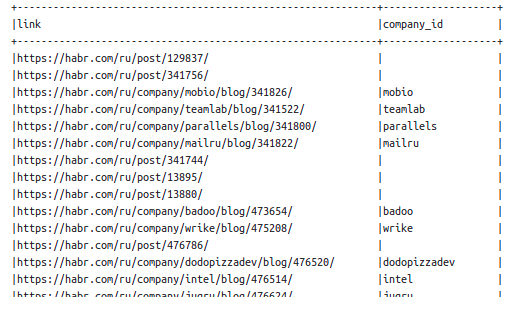

### Explode

In [ ]:
%pyspark

arrayArrayData = [
  ("James",[["Java","Scala","C++"],["Spark","Java"]]),
  ("Michael",[["Spark","Java","C++"],["Spark","Java"]]),
  ("Robert",[["CSharp","VB"],["Spark","Python"]])
]

df = spark.createDataFrame(data=arrayArrayData, schema = ['name','subjects'])
df.printSchema()
df.show(truncate=False)

from pyspark.sql.functions import explode
df2 = df.select(df.name,explode(df.subjects).alias("exploded"))
df2.show()

df2.select(df.name,explode(df2.exploded)).show(truncate=False)

df2.select(df.name,explode(df2.exploded)).printSchema()

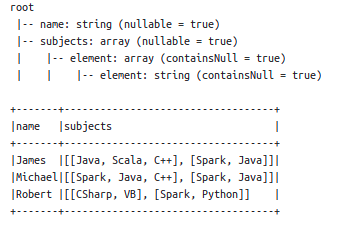

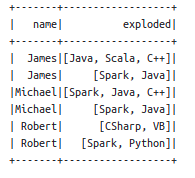

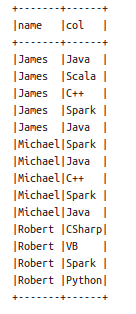

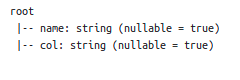

In [ ]:
%pyspark
df.schema.json()

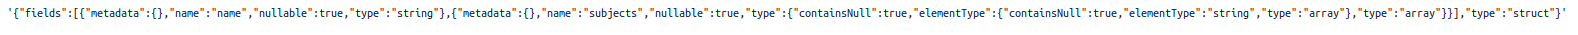

### Map to columns

In [ ]:
%pyspark

arrayData = [
        ('James',['Java','Scala'],{'hair':'black','eye':'brown'}),
        ('Michael',['Spark','Java',None],{'hair':'brown','eye':None}),
        ('Robert',['CSharp',''],{'hair':'red','eye':''}),
        ('Washington',None,None),
        ('Jefferson',['1','2'],{})
        ]

df = spark.createDataFrame(data=arrayData, schema = ['name', 'knownLanguages', 'properties'])
df.printSchema()
df.show(truncate=False)

from pyspark.sql.functions import explode
df3 = df.select(df.name,explode(df.properties))
df3.printSchema()
df3.show()

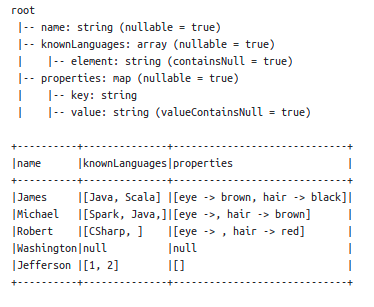

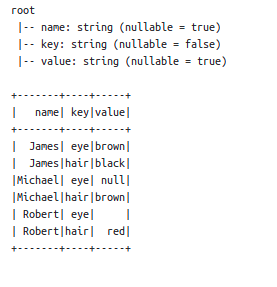

### explode_outer

In [ ]:
%pyspark
from pyspark.sql.functions import explode_outer
""" with array """
df.select(df.name,explode_outer(df.knownLanguages)).show()
""" with map """
df.select(df.name,explode_outer(df.properties)).show()

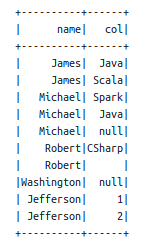

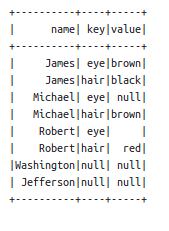

## Window functions <a class="anchor" id="wf1"></a>

### Create df for window examples

In [ ]:
%pyspark

simpleData = (("James", "Sales", 3000), 
    ("Michael", "Sales", 4600),  
    ("Robert", "Sales", 4100),   
    ("Maria", "Finance", 3000),  
    ("James", "Sales", 3000),    
    ("Scott", "Finance", 3300),  
    ("Jen", "Finance", 3900),    
    ("Jeff", "Marketing", 3000), 
    ("Kumar", "Marketing", 2000),
    ("Saif", "Sales", 4100) 
  )
 
columns= ["employee_name", "department", "salary"]
df = spark.createDataFrame(data = simpleData, schema = columns)
df.printSchema()
df.show(truncate=False)

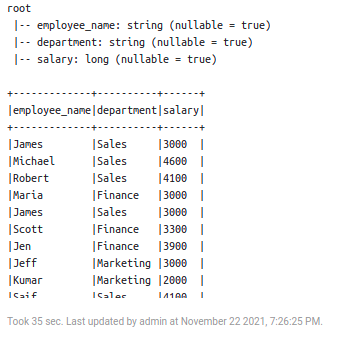

In [ ]:
%pyspark

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank, percent_rank, ntile, cume_dist, round
from pyspark.sql.types import FloatType

windowSpec  = Window.partitionBy().orderBy("salary")

df\
.withColumn("row_number", row_number().over(windowSpec)) \
.show(truncate=False)


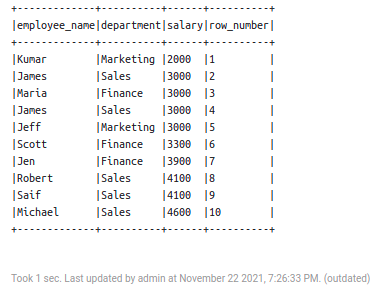

### row_number, rank

In [ ]:
%pyspark

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank, dense_rank, percent_rank, ntile, cume_dist, round
from pyspark.sql.types import FloatType

windowSpec  = Window.partitionBy("department").orderBy("salary")

df\
.withColumn("row_number", row_number().over(windowSpec)) \
.withColumn("rank", rank().over(windowSpec)) \
.withColumn("dense_rank", dense_rank().over(windowSpec)) \
.withColumn("percent_rank", percent_rank().over(windowSpec)) \
.withColumn("ntile", ntile(3).over(windowSpec)) \
.withColumn("cume_dist", round(cume_dist().over(windowSpec), 2 )) \
.show(truncate=False)


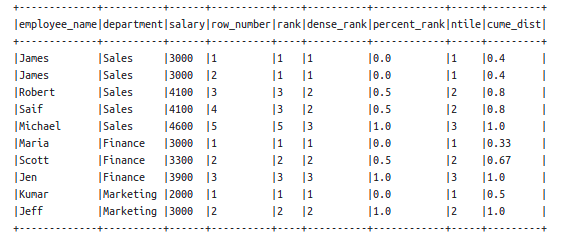

### lag Window Function


In [ ]:
%pyspark
from pyspark.sql.functions import lag, lead

df.withColumn("lag", lag("salary", 1).over(windowSpec)) \
.withColumn("lead", lead("salary", 2).over(windowSpec)) \
.show()

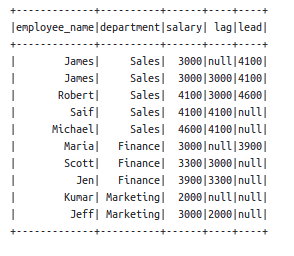

### Window Aggregate Functions

In [ ]:
%pyspark
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col,avg,sum,min,max,row_number

windowSpec     = Window.partitionBy("department").orderBy("salary")
windowSpecAgg  = Window.partitionBy("department")


df.withColumn("row", row_number().over(windowSpec)) \
.withColumn("avg_cum", avg(col("salary")).over(windowSpec)) \
.withColumn("avg", avg(col("salary")).over(windowSpecAgg)) \
.withColumn("sum_cum", sum(col("salary")).over(windowSpec)) \
.withColumn("sum", sum(col("salary")).over(windowSpecAgg)) \
.withColumn("min", min(col("salary")).over(windowSpecAgg)) \
.withColumn("max", max(col("salary")).over(windowSpecAgg)) \
.show()
# .where(col("row") == 1).select("department", "avg", "sum", "min", "max") \

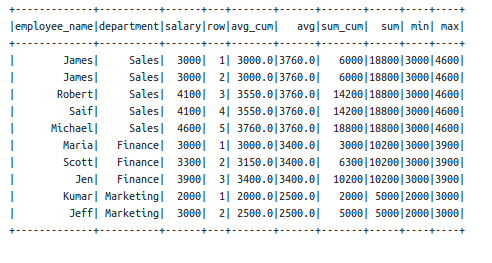

In [ ]:
%pyspark

spark.sql("with () as a, select * from ")

## UDF <a class="anchor" id="udf1"></a>

In [ ]:
%pyspark

habrData = spark.read.option("header", True).csv("/datasets/habr_data.csv")
 
from pyspark.sql.functions import udf, col, round
from pyspark.sql.types import IntegerType, FloatType
import pyspark.sql.functions as F

def mult(i):
    return i * 2

multUdf = udf(mult)

habrData \
.select("rating") \
.limit(10) \
.withColumn("udfString", multUdf(col("rating"))) \
.withColumn("udfInt", multUdf(col("rating").cast(IntegerType()))) \
.withColumn("round", round(col("udfInt")) ) \
.show()

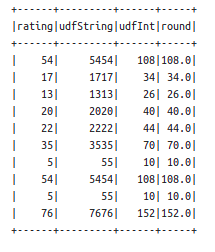

In [ ]:
%pyspark

spark.createDataFrame(([1], [2], [3]), schema="n INT").show()

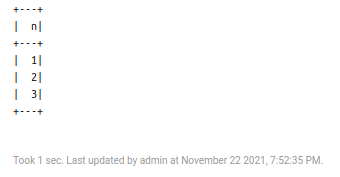

In [ ]:
%pyspark

spark.createDataFrame(([1], [2], [3]), schema="n INT") \
.selectExpr("n + 1") \
.explain()


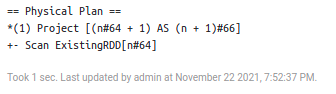

In [ ]:
%pyspark

from pyspark.sql.functions import udf, col

def plusOne(i):
    return i + 1
    
plusOneUdf = udf(plusOne)

spark.createDataFrame(([1], [2], [3]), schema="n INT")\
.select(plusOneUdf(col("n")).alias("plusOneUdf"))\
.explain()

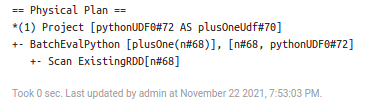

In [ ]:
%pyspark

spark.createDataFrame(([1], [2], [3]), schema="n INT")\
.selectExpr("n + 1 as plusOne")\
.where("plusOne = 2")\
.explain()

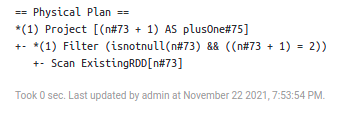

In [ ]:
%pyspark

spark.createDataFrame(([1], [2], [3]), schema="n INT")\
.withColumn("plusOne", plusOneUdf(col("n")))\
.where("plusOne = 2")\
.explain()

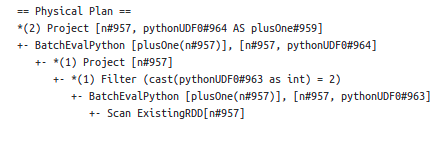

### Обработка null

In [ ]:
%pyspark

habrData = spark.read.option("header", True).csv("/datasets/habr_data.csv").cache()
 
from pyspark.sql.functions import udf, col, when, expr
from pyspark.sql.types import IntegerType

def mult(i):
    return i * 2
    
def mult_nullsafe(i):
    if i is None:
        return 0
    else:
        return i * 2
    
# multUdf = udf(mult) 
multUdf = udf(mult_nullsafe)

# .na.drop("all")\
habrData\
.select("rating")\
.withColumn("rating", col("rating").cast(IntegerType()))\
.withColumn("udfInt", multUdf(col("rating"))   )\
.show()

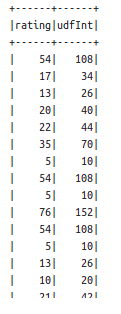

### SQL register UDF

In [ ]:
%pyspark

from pyspark.sql.functions import udf, col


spark.udf.register("mult_nullsafe", mult_nullsafe)

habrData \
.where("rating is not null") \
.withColumn("rating", col("rating").cast(IntegerType())) \
.createOrReplaceTempView("habr_data")

spark.sql("select rating, mult_nullsafe(rating) plus_one from habr_data").show()

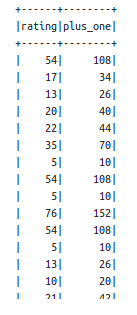

### Lambda

In [ ]:
%pyspark

# Integer type output
from pyspark.sql.types import IntegerType

def square(i):
    if i is None:
        return 0
    else:
        return i * i
    
square_udf_int = udf(lambda z: square(z), IntegerType())

habrData\
.select("rating")\
.where("rating is not null")\
.withColumn("rating", col("rating").cast(IntegerType()))\
.withColumn("square", square_udf_int(col("rating"))   )\
.show()

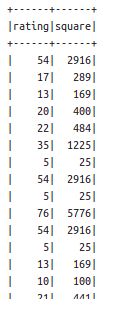

### Обработка массивов

In [ ]:
%pyspark
from pyspark.sql.types import *

def square_list_float(x):
    return [float(val)**2 for val in x]


square_list_float_udf = udf(lambda y: square_list_float(y), ArrayType(FloatType()))


cSchema = StructType([StructField("int_array", ArrayType(IntegerType()))])

df = spark.createDataFrame(
    [[[1, 2]], [[3, 4, 5]], [[6, 7, 8, 9]]], schema=cSchema
)

df.printSchema()
df.show()

df\
.withColumn("square_list_float_udf", square_list_float_udf("int_array"))\
.show()


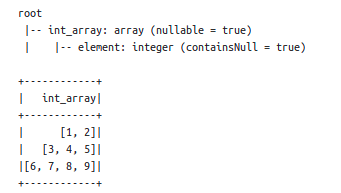

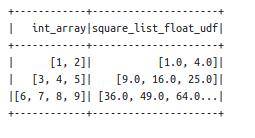

In [ ]:
%pyspark
print("https://address:port/proxy/" + sc.applicationId)

## 3 Лекция - DataFrame API 2 HOMEWORK <a class="anchor" id="uhw3"></a>

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events").where("date < '2019-11-02'")

events_df.show()

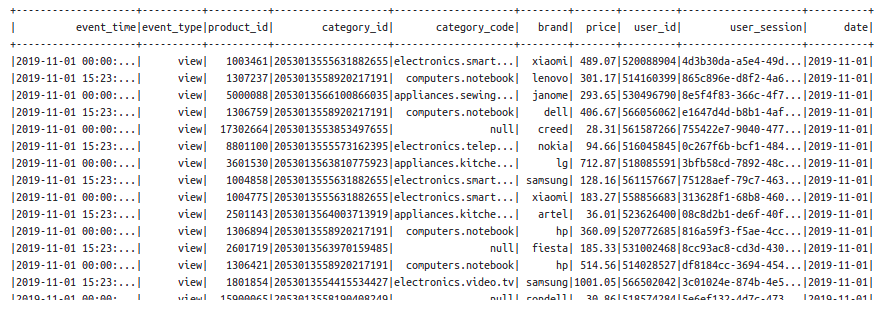

In [ ]:
1 - Добавить колонки category_1, category_2, category_3 с категориями различного уровня

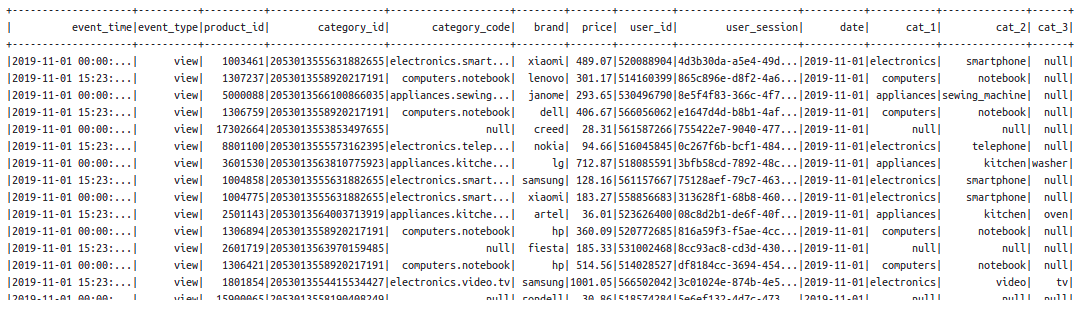

In [ ]:
2 - Вывести топ-3 брендов по количеству просмотров для каждой категории 2-го уровня

In [ ]:
### создание hw_3.tracks для запуска локально (на кластере уже готова)

%pyspark

import pyspark.sql.functions as f
from pyspark.sql.types import *

sch=ArrayType(StringType());

# скачать датасет: http://37.139.43.86/tracks 

# важно что разделитель ', ' с пробелом, иначе пробелы добавятся в значения
tracks = spark.read.option("header", "true") \
        .option("escape", '"') \
        .option("InferSchema", "true") \
        .csv("data/tracks.csv") \
        .withColumn("release_year", f.substring("release_date", 1, 4).cast(IntegerType())) \
        .withColumn("array_artist", f.split(f.regexp_replace(f.col("artists"), "[\]\[\']", ""),", ")) \
        .cache() #выделяем год в отдельную колонку и преобразуем колонку с артистами в массив

tracks_exp = tracks.select(  
                            "name", 
                            "popularity",
                            "danceability",
                            "energy",
                            "speechiness",
                            "acousticness",
                            "liveness",
                            "valence",
                            "release_year",
                            "artists",
                            f.explode(f.col("array_artist") ).alias("name_artist")
                        ) #создаем отдельную таблицу с развернутым массивом артистов
                        
tracks_exp.printSchema()

spark.sql("create database hw_3")
tracks_exp.write.mode("overwrite").saveAsTable("hw_3.tracks")

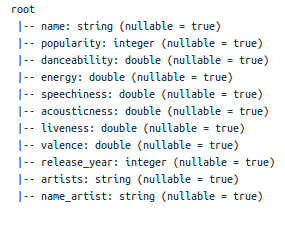

In [ ]:
%pyspark

tracks = spark.table("hw_3.tracks")
tracks.show()

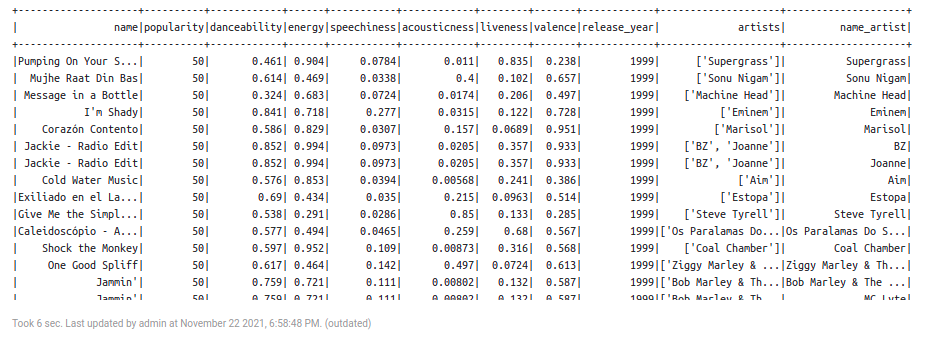

In [ ]:
2.1. Какие артисты выпустили наибольшее число песен из годовых топ-100 (по популярности)?

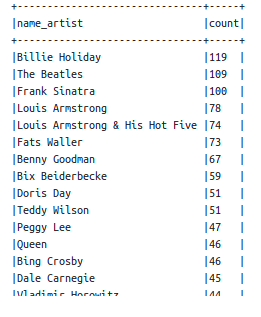

In [ ]:
2.2. Вывести топ артистов, которые чаще других попадали в годовой топ-100 песен по популярности?

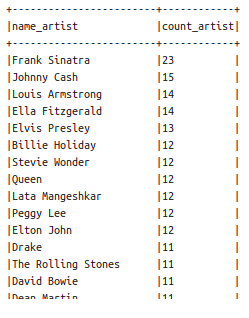

In [ ]:
*2.3. Какие артисты дольше других несколько лет подряд держались в ежегодном топ-100 песен по популярности?

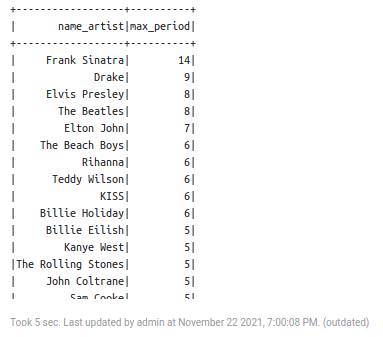

In [ ]:
*2.4. Для каждой аудиохарактеристики вывести топ 3 артистов по среднему значению каждой аудиохарактеристики его песен. 
Дополнительно: отнормировать на среднее значение аудиохарактеристики в год выхода песен.

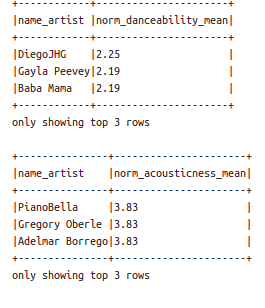

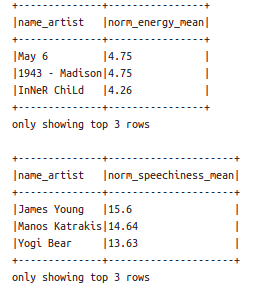

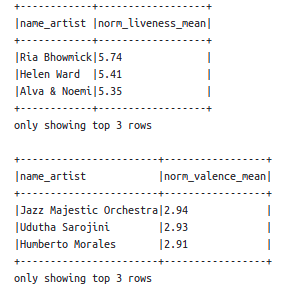

## 4 Лекция - Оптимизация запросов <a class="anchor" id="l4"></a>

In [ ]:
%sh

hdfs dfs -ls -h /apps/hive/warehouse/market.db/events/date=2019-11-08

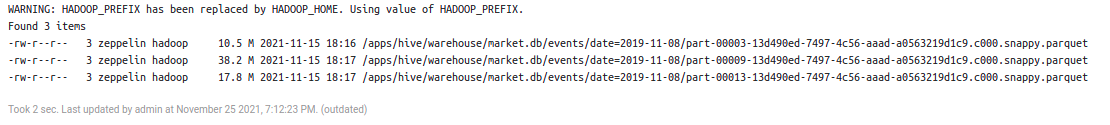

In [ ]:
%conf

spark.executor.memory=512mb

In [ ]:
%pyspark
spark.table("hw_4.events_full").show()

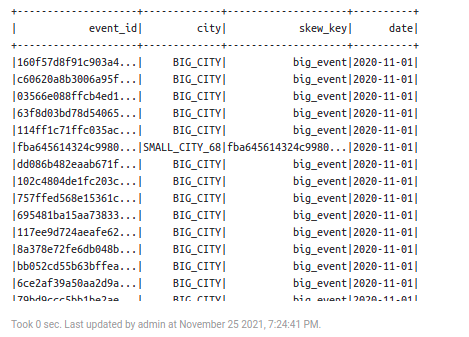

In [ ]:
spark.table("hw_4.events_full")
.select("event_id")
.sample(0.006)
.repartition(1)
.write.mode("overwrite")
.saveAsTable("hw_4.sample_big")

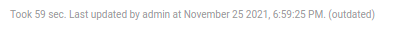

In [ ]:
spark.table("hw_4.events_full")
.select("event_id")
.sample(0.03)
.repartition(1)
.write.mode("overwrite")
.saveAsTable("hw_4.sample_very_big")

In [ ]:
%pyspark

sample_very_big_df = spark.table("hw_4.sample_very_big")
sample_big_df = spark.table("hw_4.sample_big")

sample_very_big_df.join(sample_big_df, "event_id", "leftsemi").count()

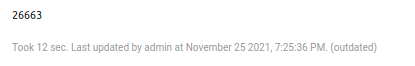

In [ ]:
%pyspark

spark.table("hw_4.sample_very_big") \
.write.mode("overwrite").bucketBy(10, "event_id") \
.saveAsTable("hw_4.sample_very_big_bucket")


spark.table("hw_4.sample_big") \
.write.mode("overwrite").bucketBy(10, "event_id") \
.saveAsTable("hw_4.sample_big_bucket")

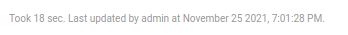

In [ ]:
%sh

hdfs dfs -ls -h /apps/hive/warehouse/hw_4.db/sample_big

hdfs dfs -ls -h /apps/hive/warehouse/hw_4.db/sample_very_big

hdfs dfs -ls -h /apps/hive/warehouse/hw_4.db/sample_very_big_bucket


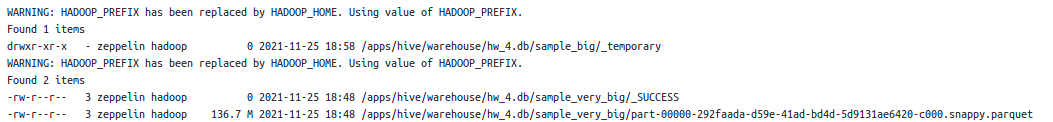

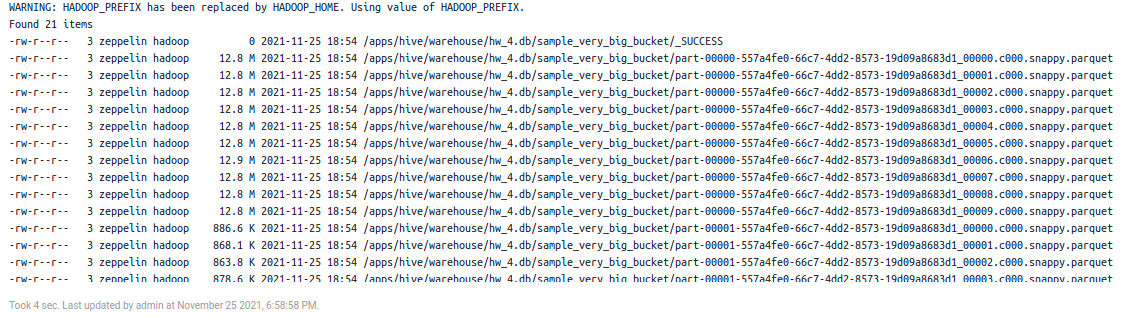

In [ ]:
%pyspark

sample_very_big_df = spark.table("hw_4.sample_very_big_bucket")
sample_big_df = spark.table("hw_4.sample_big_bucket")

sample_very_big_df.join(sample_big_df, "event_id", "leftsemi").count()


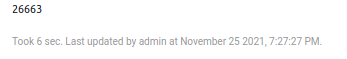

### Skew data

In [ ]:
%pyspark

from pyspark.sql.functions import when, lit, col

skew_column = when(col("id") < 900, lit(0)).otherwise(lit(1)).alias("skew_column")

skewed_df = spark.range(1000).withColumn("skew", skew_column).repartition(10, col("skew"))

skewed_df.show()

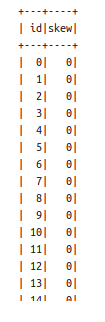

In [ ]:
%pyspark

def print_parts(df):
    ret = df.rdd.mapPartitions(lambda x: [len(list(x))]).collect()
    print(ret)
    
print_parts(skewed_df)

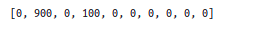

In [ ]:
%pyspark
# здесь мы передаем только новое количество партиций и Spark выполнит RoundRobinPartitioning

balanced_df = skewed_df.repartition(11)
print_parts(balanced_df)

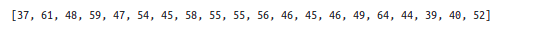

## Добавление соли<a class="anchor" id="salt1"></a>

In [ ]:
%sh

curl https://github.com/datasets/airport-codes/raw/master/data/airport-codes.csv  > airport-codes.csv

hdfs dfs -put airport-codes.csv data

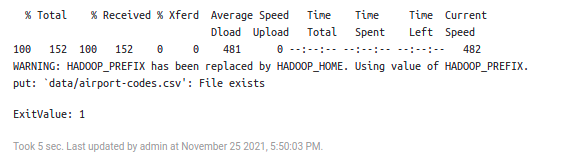

In [ ]:
%sparkLocal.pyspark
import pyspark.sql.functions as f

df = spark.read.format("csv").options(header=True, inferSchema=True).load("data/airport-codes.csv")

df.groupBy(f.col("type")).count().orderBy(f.col("count").desc()).show(30, False)
df.show()

# тут какая-то ошибка

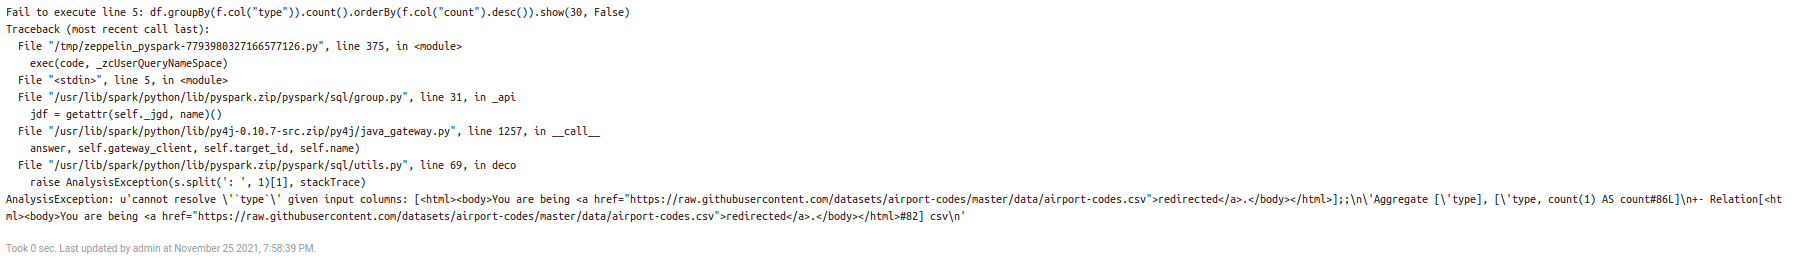

In [ ]:
%pyspark
from pyspark.sql.functions import collect_list, col

skew_grouped = df.groupBy(col("type")).agg(collect_list(col("ident")).alias("ids"))
skew_grouped.show(20, 100)

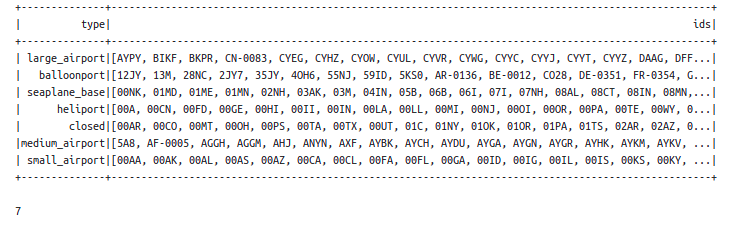

Поскольку при вычислении агрегата происходит неявный HashPartitioning по ключу (ключам) агрегата, то при выполнении определенных условий происходит нехватка памяти на воркере, которую нельзя исправить, не изменив подход к построению агрегата.

Один из вариантов устранение - соление ключей:

In [ ]:
%pyspark
from pyspark.sql.functions import expr

salt = expr("""pmod(round(rand() * 100, 0), 10)""").cast("integer")
salted = df.withColumn("salt", salt)
salted.select(col("type"), col("ident"), col("salt")).sample(0.1).show(20, False)

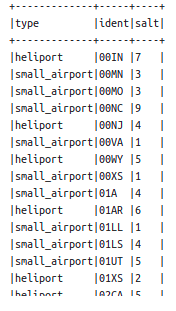

Это позволяет нам существенно снизить объем данных в каждой партиции (30к vs 3к):

In [ ]:
%pyspark

salted.groupBy(col("type"), col("salt")).count().orderBy(col("count").desc()).show(20, False)


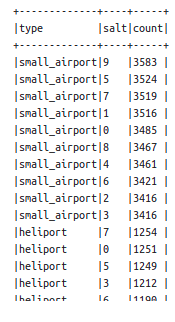

Это позволяет нам посчитать требуемый агрегат более оптимальным путем, не смотря на появление второго агрегата:

In [ ]:
%pyspark

salted \
    .groupBy(col("type"), col("salt")).agg(collect_list(col("ident")).alias("ids")) \
    .groupBy(col("type")).agg(collect_list(col("ids")).alias("ids")) \
    .show(20, 100)

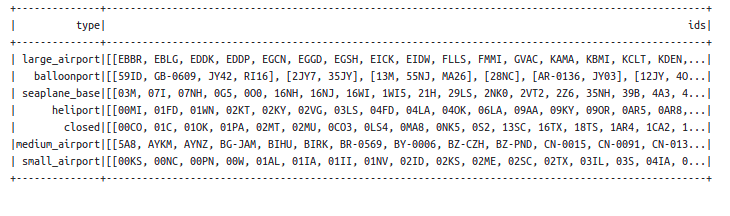

### Кеширование

По умолчанию при применении каждого действия Spark пересчитывает весь граф, что может негативно сказать на производительности приложения. Для демонстрации возьмем датасет Airport Codes
Посчитаем несколько действий. Несмотря на то, что only_ru является общим для всех действий, он пересчитывается при вызове каждого действия.

In [ ]:
%pyspark
only_ru = df.filter((col("iso_country") == "RU") & (col("elevation_ft") > 1000))
only_ru.show(1, 50, True)

only_ru.count()
only_ru.collect()
only_ru.groupBy(col("municipality")).count().orderBy(col("count").desc()).na.drop("any").show()

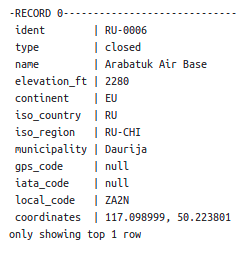

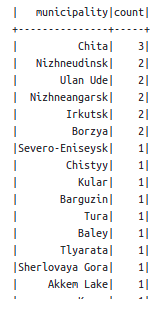

Для решения этой проблемы следует использовать методы cache, либо persist. Данные методы сохраняют состояние графа после первого действия, и следующие обращаются к нему. Разница между методами заключается в том, что persist позволяет выбрать, куда сохранить данные, а cache использует значение по умолчанию. В текущей версии Spark это StorageLevel.MEMORY_ONLY. Важно помнить, что данный кеш не предназначен для обмена данными между разными Spark приложения - он является внутренним для приложения. После того, как работа с данными окончена, необходимо выполнить unpersist для очистки памяти

In [ ]:
%pyspark
only_ru = df.filter((col("iso_country") == "RU") & (col("elevation_ft") > 1000))
only_ru.cache()
only_ru.show(1, 50, True)
only_ru.count()
only_ru.collect()
only_ru.groupBy(col("municipality")).count().orderBy(col("count").desc()).na.drop("any").show()
# only_ru.unpersist()

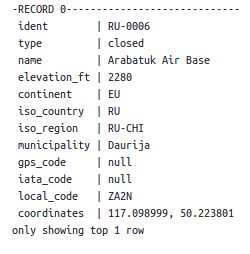

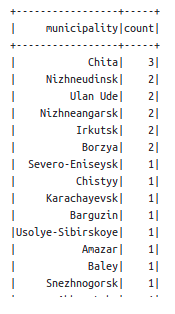

In [ ]:
%pyspark

only_ru.groupBy(col("municipality")).count().orderBy(col("count").desc()).na.drop("any").show()

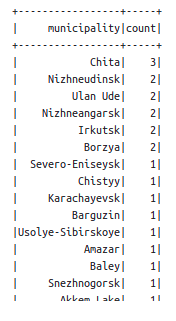

## Планы выполнения задач<a class="anchor" id="plan1"></a>

Любой job в Spark SQL имеет под собой план выполнения, кототорый генерируется на основе написанно запроса. План запроса содержит операторы, которые затем превращаются в Java код. Поскольку одну и ту же задачу в Spark SQL можно выполнить по-разному, полезно смотреть в планы выполнения, чтобы, например:

убрать лишние shuffle<br/>
убедиться, чтот тот или иной оператор будет выполнен на уровне источника, а не внутри Spark<br/>
понять, как будет выполнен join<br/>
Планы выполнения доступны в двух видах:<br/>

метод explain() у DF<br/>
на вкладке SQL в Spark UI

In [ ]:
%pyspark
from pyspark.sql.functions import col

df.filter(col("type") == "small_airport").explain(extended=True)

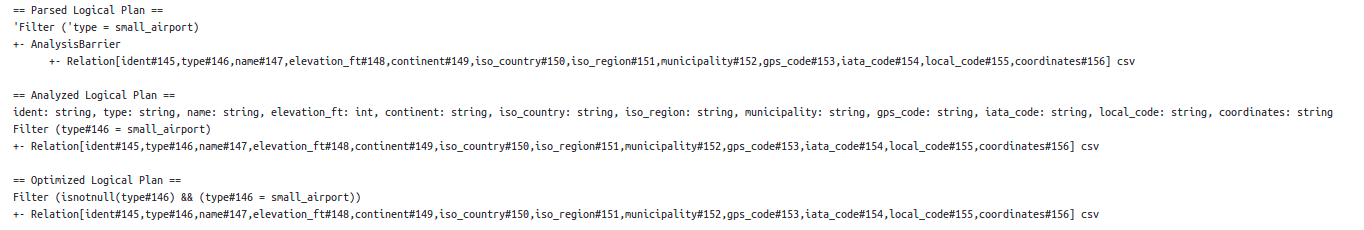

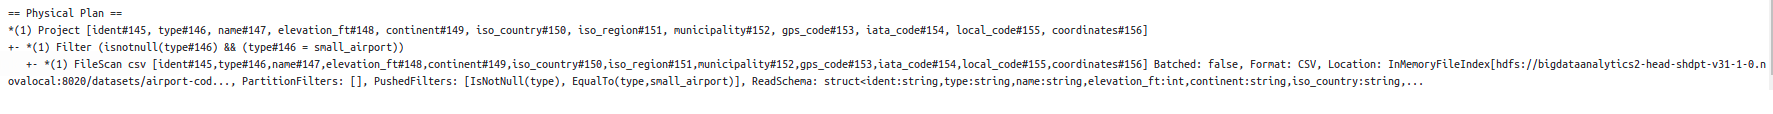

Выполним агрегацию и проверим план выполнения. В нем появляется три оператора: 2 HashAggregate и Exchange hashpartitioning.

Первый HashAggregate содержит функцию partial_count(1). Это означает, что внутри каждого воркера произойдет подсчет строк по каждому ключу. Затем происходит shuffle по ключу агрегата, после которого выполняется еще один HashAggregate с функцией count(1). Использование двух HashAggregate позволяет сократить количество передаваемых данных по сети.

In [ ]:
%pyspark
from pyspark.sql.functions import col

df.filter(col("type") == "small_airport").groupBy(col("iso_country")).count().explain()

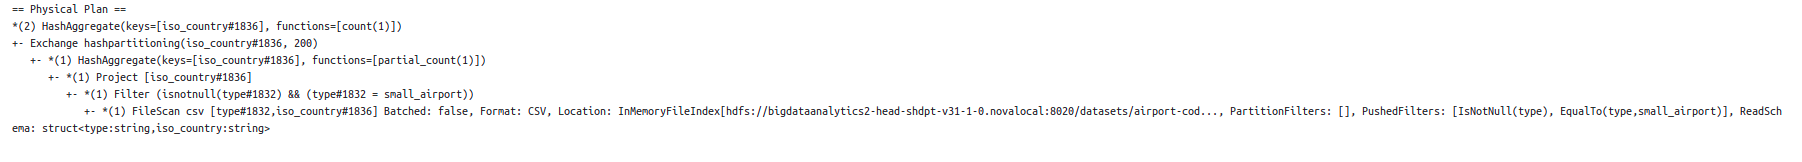

## Оптимизация соединений и группировок<a class="anchor" id="plan2"></a>

При выполнении join двух DF важно следовать рекомендациям:

- фильтровать данные до join’а
- использовать equ join
- если можно путем увеличения количества данных применить equ join вместо non-equ join’а, то делать именно так
- всеми силами избегать cross-join’ов
- если правый DF помещается в памяти worker’а, использовать broadcast()

<b>Виды джойнов</b>

BroadcastHashJoin
- equ join
- broadcast

SortMergeJoin
- equ join
- sortable keys

BroadcastNestedLoopJoin
- non-equ join
- using broadcast

CartesianProduct
- non-equ join

In [ ]:
%pyspark

df.show()

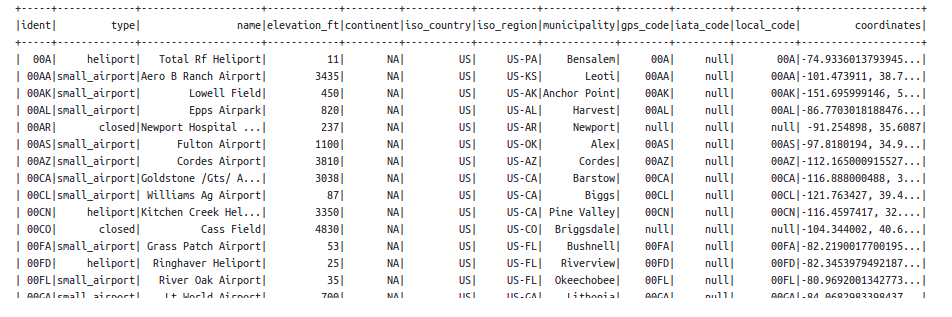

In [ ]:
%pyspark
left = df.select(col("type"), col("ident"), col("iso_country")).alias("left").localCheckpoint()
right = df.groupBy(col("type")).count().alias("right").localCheckpoint()

### BroadcastHashJoin¶

- работает, когда условие - равенство одного или нескольких ключей
- работает, когда один из датасетов небольшой и полностью вмещается в память воркера
- оставляет левый датасет как есть
- копирует правый датасет на каждый воркер
- составляет hash map из правого датасета, где ключ - кортеж из колонок в условии соединения
- итерируется по левому датасета внутри каждой партиции и проверяет наличие ключей в HashMap
- может быть автоматически использован, либо явно через broadcast(df)

In [ ]:
%pyspark
from pyspark.sql.functions import broadcast

result = left.join(broadcast(right), "type", "inner")
# result = left.join(right, "type", "inner")

result.explain()

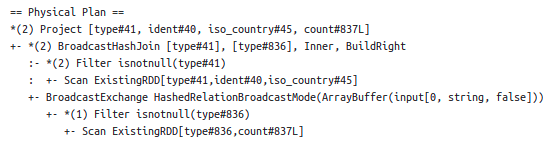

### SortMergeJoin

- работает, когда ключи соединения в обоих датасета являются сортируемыми
- репартиционирует оба датасета в 200 партиций по ключу (ключам) соединения
- -сортирует партиции каждого из датасетов по ключу (ключам) соединения
- Используя сравнение левого и правого ключей, обходит каждую пару партиций и соединяет строки с одинаковыми ключами

In [ ]:
%pyspark
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")

result = left.join(right, "type", "inner")

result.explain()

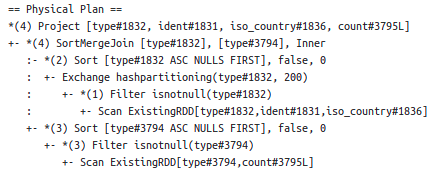

BroadcastNestedLoopJoin

- работает, когда один из датасетов небольшой и полностью вмещается в память воркера
- оставляет левый датасет как есть
- копирует правый датасет на каждый воркер
- проходится вложенным циклом по каждой партиции левого датасета и копией правого датасета и проверяет условие
- может быть автоматически использован, либо явно через broadcast(df)

In [ ]:
%pyspark
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")

result = left.join(broadcast(right), left["type"] != right["type"], "inner")

result.explain()

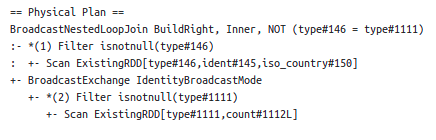

### CartesianProduct

- Создает пары из каждой партиции левого датасета с каждой партицией правого датасета, релоцирует каждую пару на один воркер и проверяет условие соединения
- на выходе создает N*M партиций
- работает медленнее остальных и часто приводит к ООМ воркеров

In [ ]:
%pyspark
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")

result = left.join(right, left["type"] != right["type"], "inner")

result.explain()

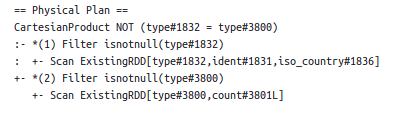

### Снижение количества shuffle

В ряде случаев можно уйти от лишних shuffle операций при выполнении соединения. Для этого оба DF должны иметь одинаковое партиционирование - одинаковое количество партиций и ключ партиционирования, совпадающий с ключом соединения.

Разница между планами выполнения будет хорошо видна в Spark UI на графе выполнения в Jobs и плане выполнения в SQL

In [ ]:
%pyspark

df.unpersist()

left = df
right = df.groupBy(col("type")).count()
joined = left.join(right, "type")
joined.count()

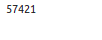

In [ ]:
%pyspark

df_rep = df.repartition(200, col("type"))

left = df_rep
right = df_rep.groupBy(col("type")).count()

joined = left.join(right, "type")
joined.count()

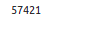

In [5]:
# там по идее должно быть разное время исполнения

### Оптимизатор запросов Catalyst

Catalyst выполняет оптимизацию запросов с целью ускорения их выполнения и применяет следующие методы:

- Column projection
- Partition pruning
- Predicate pushdown
- Constant folding


Подготовим датасет для демонстрации работы Catalyst:

In [ ]:
%pyspark
df \
    .write \
    .format("parquet") \
    .partitionBy("iso_country") \
    .mode("overwrite") \
    .save("/tmp/airports.parquet") 

airports = spark.read.parquet("/tmp/airports.parquet")
airports

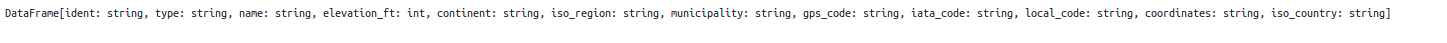

In [ ]:
%sh
hdfs dfs -ls /tmp/airports.parquet

# разбивка по странам

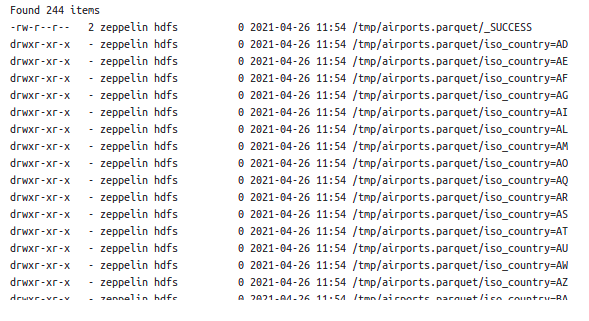

In [ ]:
%sh

hdfs dfs -ls /tmp/airports.parquet/iso_country=AD

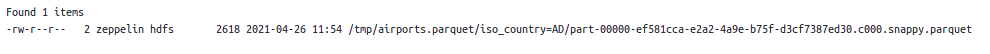

In [ ]:
%pyspark

spark.read.parquet("/tmp/airports.parquet/iso_country=AD/part-00000-ef581cca-e2a2-4a9e-b75f-d3cf7387ed30.c000.snappy.parquet").printSchema()

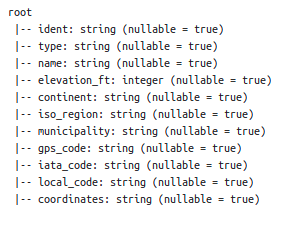

### Column projection

Данный механизм позволяет избегать вычитывания ненужных колонок при работе с источниками

In [ ]:
%pyspark
selected = airports.select(col("ident"))
selected.cache()
selected.count()
selected.unpersist()
selected.explain()

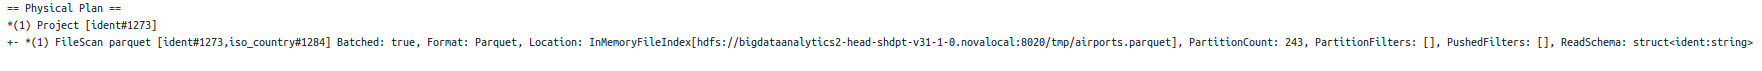

In [ ]:
%pyspark
selected = airports
selected.cache()
selected.count()
selected.unpersist()
selected.explain()

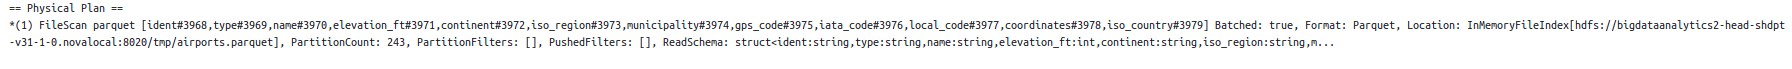

### Partition pruning

Данный механизм позволяет избежать чтения ненужных партиций

In [ ]:
%pyspark
filtered = airports.filter(col("iso_country") == "RU")
filtered.count()
filtered.explain(True)

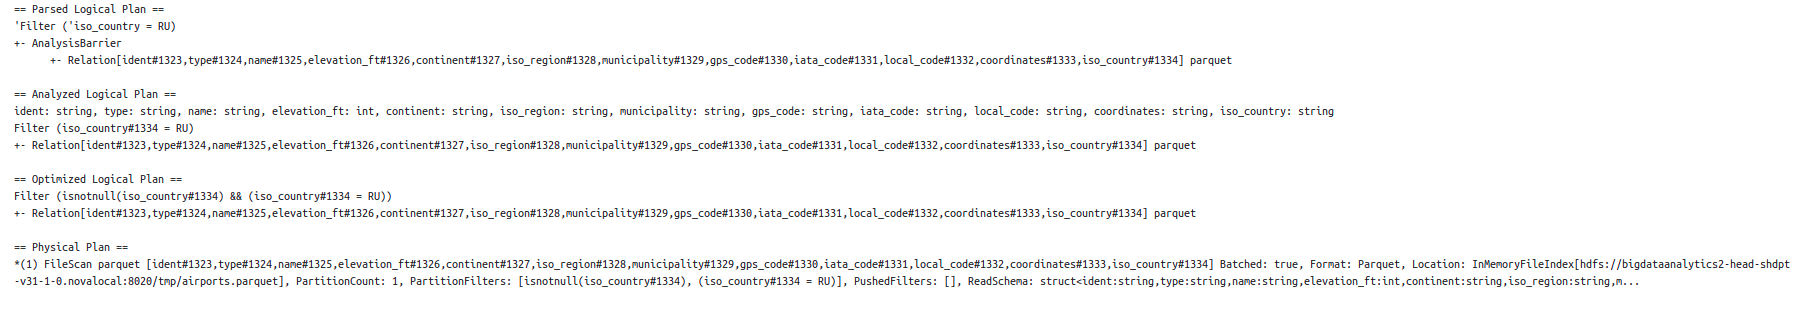

### Predicate pushdown

Данный механизм позволяет “протолкнуть” условия фильтрации данных на уровень datasource

In [ ]:
%pyspark
filtered = airports.filter(col("iso_region") == "RU")
filtered.count()
filtered.explain()

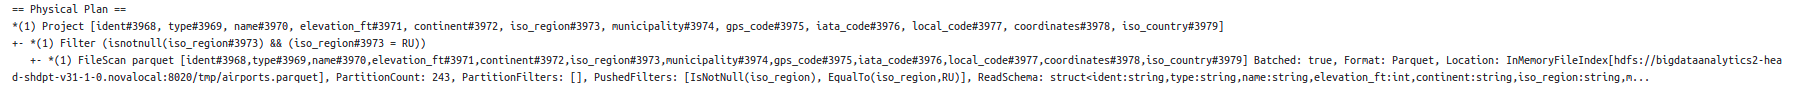

### Simplify casts

Данный механизм убирает ненужные cast

In [ ]:
%pyspark
result = spark.range(10).select(col("id").cast("long"))
result.explain(True)

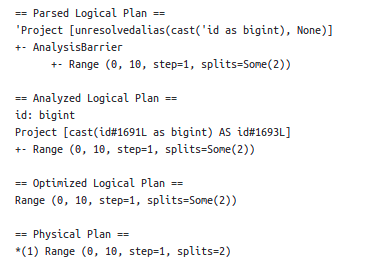

In [ ]:
%pyspark
result = spark.range(10).select(col("id").cast("int").cast("long"))
result.explain(True)

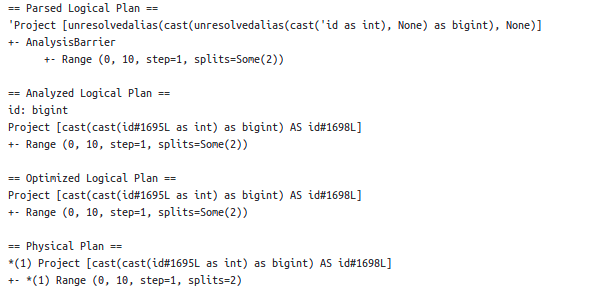

### Constant folding

Данный механизм сокращает количество констант, используемых в физическом плане

In [ ]:
%pyspark
from pyspark.sql.functions import lit

result = spark.range(10).select((lit(3) > lit(0)).alias("foo"))
result.explain(True)

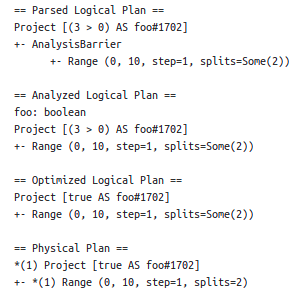

In [ ]:
%pyspark
from pyspark.sql.functions import lit, col

result = spark.range(10).select((col("id") >  lit(0)).alias("foo"))
result.explain(True)

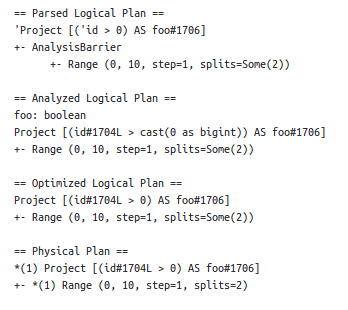

### Combine filters

Данный механизм объединяет фильтры

In [ ]:
%pyspark

result = spark.range(10).filter(col("id") > 0) \
    .filter(col("id") != 5) \
    .filter(col("id") < 10)
    
result.explain(True)


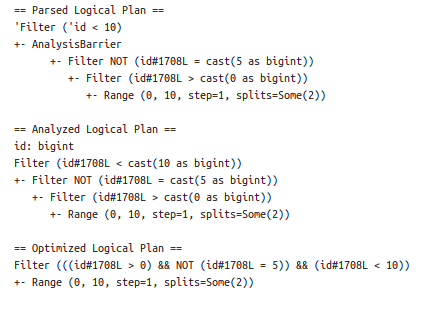

## 4 Лекция - Оптимизация запросов HOMEWORK<a class="anchor" id="uhw4"></a>

### Генерация events таблицы (код для ознакомления, запускать не нужно)

In [ ]:
import org.apache.spark.mllib.random.RandomRDDs._
import java.time.LocalDate
import java.time.format.DateTimeFormatter

val dates = (0 to 14).map(LocalDate.of(2020, 11, 1).plusDays(_).format(DateTimeFormatter.ofPattern("yyyy-MM-dd"))).toSeq

def generateCity(r: Double): String = if (r < 0.9) "BIG_CITY" else "SMALL_CITY_" + scala.math.round((r - 0.9) * 1000)

def generateCityUdf = udf(generateCity _)

// spark.sql("drop table hw2.events_full")

for(i <- dates) {
    uniformRDD(sc, 10000000L, 1)
    .toDF("uid")
    .withColumn("date", lit(i))
    .withColumn("city", generateCityUdf($"uid"))
    .selectExpr("date", " sha2(cast(uid as STRING), 256) event_id", "city")
    .withColumn("skew_key", when($"city" === "BIG_CITY", lit("big_event")).otherwise($"event_id"))
    .write.mode("append")
    .partitionBy("date")
    .saveAsTable("hw_4.events_full")
}


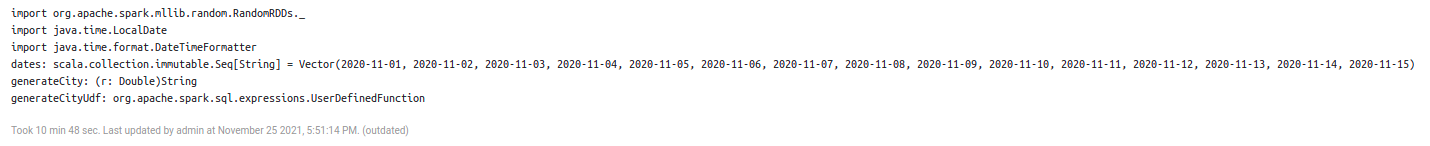

### Генерация events_sample

In [ ]:
spark.table("hw_4.events_full")
.select("event_id")
.sample(0.001)
.repartition(2)
.write.mode("overwrite")
.saveAsTable("hw_4.sample")


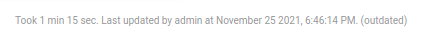

In [ ]:
spark.table("hw_4.sample")
.limit(100)
.coalesce(1)
.write.mode("overwrite")
.saveAsTable("hw_4.sample_small")

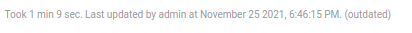

In [ ]:
spark.table("hw_4.events_full")
.select("event_id")
.sample(0.003)
.repartition(1)
.write.mode("overwrite")
.saveAsTable("hw_4.sample_big")

In [ ]:
spark.table("hw_4.events_full")
.select("event_id")
.sample(0.015)
.repartition(1)
.write.mode("overwrite")
.saveAsTable("hw_4.sample_very_big")

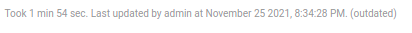

### Задание 1

Для упражнений сгрененирован большой набор синтетических данных в таблице hw2.events_full. Из этого набора данных созданы маленькие (относительно исходного набора) таблицы разного размера kotelnikov.sample_[small, big, very_big].

Ответить на вопросы:

- какова структура таблиц
- сколько в них записей
- сколько места занимают данные

### Задание 2
.
.
.

Получить планы запросов для джойна большой таблицы hw2.events_full с каждой из таблиц hw2.sample, hw2.sample_big, hw2.sample_very_big по полю event_id. В каких случаях используется BroadcastHashJoin?

BroadcastHashJoin автоматически выполняется для джойна с таблицами, размером меньше параметра spark.sql.autoBroadcastJoinThreshold. Узнать его значение можно командой spark.conf.get(“spark.sql.autoBroadcastJoinThreshold”).

### Задание 3
.
.
.

Выполнить джойны с таблицами hw2.sample, hw2.sample_big в отдельных параграфах, чтобы узнать время выполнения запросов (например, вызвать .count() для результатов запросов). Время выполнения параграфа считается автоматически и указывается в нижней части по завершении

Зайти в spark ui (ссылку сгенерировать в следующем папраграфе). Сколько tasks создано на каждую операцию? Почему именно столько? Каков DAG вычислений?

### Генерация ссылки на  spark UI

println("host:port/proxy/" + sc.applicationId + "/jobs/")

### Насильный broadcast

Оптимизировать джойн с таблицами hw2.sample_big, hw2.sample_very_big с помощью broadcast(df). Выполнить запрос, посмотреть в UI, как поменялся план запроса, DAG, количество тасков. Второй запрос не выполнится

In [ ]:
%pyspark

spark.table("hw_4.events_full")\
.join(broadcast(spark.table("hw_4.sample")), "event_id")

### Отключение auto broadcast

Отключить автоматический броадкаст командой spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1"). Сделать джойн с семплом hw_4.sample, сравнить время выполнения запроса.

### Вернуть настройку к исходной

spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "26214400")

### Задание 4
.
.
.

В процессе обработки данных может возникнуть перекос объёма партиций по количеству данных (data skew). В таком случае время выполнения запроса может существенно увеличиться, так как данные распределятся по исполнителям неравномерно. В следующем параграфе происходит инициализация датафрейма, этот параграф нужно выполнить, изменять код нельзя. В задании нужно работать с инициализированным датафреймом.

Датафрейм разделен на 30 партиций по ключу city, который имеет сильно неравномерное распределение.



### нужно выполнить, изменять код нельзя
  


In [ ]:
%pyspark 
from pyspark.sql.functions import col

skew_df = spark.table("hw_4.events_full")\
.where("date = '2020-11-01'")\
.repartition(30, col("city"))\
.cache()

skew_df.count()

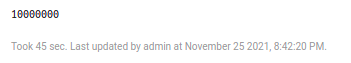

### 4.1. Наблюдение проблемы
.
.
.

Посчитать количество event_count различных событий event_id , содержащихся в skew_df с группировкой по городам. Результат упорядочить по event_count.

В spark ui в разделе jobs выбрать последнюю, в ней зайти в stage, состоящую из 30 тасков (из такого количества партиций состоит skew_df). На странице стейджа нажать кнопку Event Timeline и увидеть время выполнения тасков по экзекьюторам. Одному из них выпала партиция с существенно большим количеством данных. Остальные экзекьюторы в это время бездействуют – это и является проблемой, которую предлагается решить далее.

### 4.2. repartition
  
один из способов решения проблемы агрегации по неравномерно распределенному ключу является предварительное перемешивание данных. Его можно сделать с помощью метода repartition(p_num), где p_num -- количество партиций, на которые будет перемешан исходный датафрейм

### 4.3. Key Salting

.
.
.
Другой способ исправить неравномерность по ключу – создание синтетического ключа с равномерным распределением. В нашем случае неравномерность исходит от единственного значения city='BIG_CITY', которое часто повторяется в данных и при группировке попадает к одному экзекьютору. В таком случае лучше провести группировку в два этапа по синтетическому ключу CITY_SALT, который принимает значение BIG_CITY_rand (rand – случайное целое число) для популярного значения BIG_CITY и CITY для остальных значений. На втором этапе восстанавливаем значения CITY и проводим повторную агрегацию, которая не занимает времени, потому что проводится по существенно меньшего размера данным.

Такая же техника применима и к джойнам по неравномерному ключу, см, например https://itnext.io/handling-data-skew-in-apache-spark-9f56343e58e8

Что нужно реализовать:

добавить синтетический ключ
группировка по синтетическому ключу
восстановление исходного значения
группировка по исходной колонке

## 5 Лекция - RDD <a class="anchor" id="l5"></a>

### RDD

In [ ]:
%pyspark

mydata = [1, 2, 2, 3, 4, 5, 5, 5, 6]

rdd = sc.parallelize(mydata)

rdd.collect()

### map()

In [ ]:
%pyspark

new_RDD = rdd.map(lambda x: x * 2)

new_RDD.take(10)


### filter()

In [ ]:
%pyspark
new_RDD = rdd.filter(lambda x: x >= 4)

new_RDD.take(10)

### distinct()

In [ ]:
%pyspark

new_RDD = rdd.distinct()

new_RDD.take(10)

### union()

In [ ]:
%pyspark

rdd2 = sc.parallelize([2, 2, 3, 5, 6, 6, 7, 8, 9])
new_RDD = rdd.union(rdd2)
new_RDD.take(20)

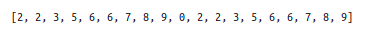

### reduce

In [ ]:
%pyspark

rdd.reduce(lambda x, y: x + y)

### intersection()


In [ ]:
%pyspark

new_RDD = rdd.intersection(rdd2)

new_RDD.take(10)

### subtract()

In [ ]:
%pyspark

new_RDD = rdd.subtract(rdd2)

new_RDD.take(10)

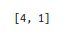

### sample()


In [ ]:
%pyspark

new_RDD = rdd.sample(False, 0.5)

new_RDD.collect()

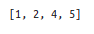

## PAIR RDD Transformations<a class="anchor" id="rdd1"></a>

### groupByKey()

In [ ]:
%pyspark

rdd=sc.parallelize([ 
    (1, 2),
    (1, 5),
    (3, 4),
    (3, 6)])

rdd.groupByKey().collect()


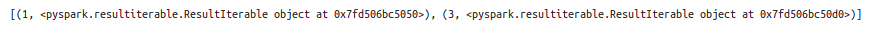

### reduceByKey()

In [ ]:
%pyspark

rdd.groupByKey().map(lambda x:(x[0], list(x[1])) ).collect()

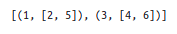

In [ ]:
%pyspark

rdd.groupByKey().map(lambda x:(x[0], sum(x[1])) ).collect()

### reduceByKey()

In [ ]:
%pyspark

rdd.reduceByKey(lambda x, y: x + y).collect()

### sortByKey()

In [ ]:
%pyspark

rdd.sortByKey(ascending=False).collect()

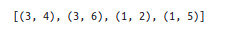

### subtractByKey()

In [ ]:
%pyspark

rdd2=sc.parallelize([(1,9)])

rdd.subtractByKey(rdd2).collect()

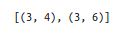

### countByKey()

In [ ]:
%pyspark

rdd.countByKey().items()

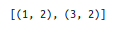

### join()

In [ ]:
%pyspark

rdd.join(rdd2).collect()

### RDD Actions

- collect()
- take()
- count()
- top()
- reduce()
- first()
- sum()
- aggregate()

### collect()

In [ ]:
%pyspark

rdd = sc.parallelize([2, 2, 3, 5, 6, 6, 7, 8, 9, 0])

rdd.collect()


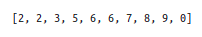

In [ ]:
%pyspark

new_rdd=sc.parallelize([1, 2, 3, 4])

new_rdd.aggregate((0, 0), 
    (lambda x, y:(x[0] + y, x[1] + 1)), 
    (lambda x, y:(x[0] + y[0], x[1] + y[1])) )


In [ ]:
%pyspark

# In Python
# Create an RDD of tuples (name, age)

dataRDD = sc.parallelize(
    [("Brooke", 20), ("Denny", 31), ("Jules", 30), ("TD", 35), ("Brooke", 25)]
    )

# Use map and reduceByKey transformations with their lambda
# expressions to aggregate and then compute average

agesRDD = (dataRDD
.map(lambda x: (x[0], (x[1], 1)))
.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
.map(lambda x: (x[0], x[1][0] / x[1][1])))

agesRDD.take(10)

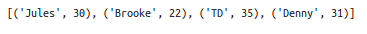

In [ ]:
%pyspark

dataRDD\
.map(lambda x: (x[0], (x[1], 1))) \
.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])).take(10)

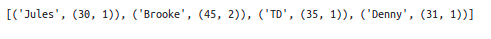

In [ ]:
%pyspark

from pyspark.sql.functions import avg

data_df = spark.createDataFrame([("Brooke", 20), ("Denny", 31), ("Jules", 30),
("TD", 35), ("Brooke", 25)], ["name", "age"])

# Group the same names together, aggregate their ages, and compute an average
avg_df = data_df.groupBy("name").agg(avg("age"))

avg_df.show()

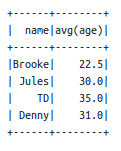

### Broadcast read-only Variables

In [ ]:
%pyspark

states = {"NY":"New York", "CA":"California", "FL":"Florida"}
broadcastStates = spark.sparkContext.broadcast(states)

data = [("James","Smith","USA","CA"),
    ("Michael","Rose","USA","NY"),
    ("Robert","Williams","USA","CA"),
    ("Maria","Jones","USA","FL")
  ]

columns = ["firstname","lastname","country","state"]
df = spark.createDataFrame(data = data, schema = columns)
df.printSchema()
df.show(truncate=False)

def state_convert(code):
    return broadcastStates.value[code]

result = df.rdd.map(lambda x: (x[0],x[1],x[2],state_convert(x[3]))).toDF(columns)
result.show(truncate=False)

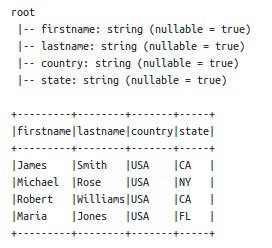

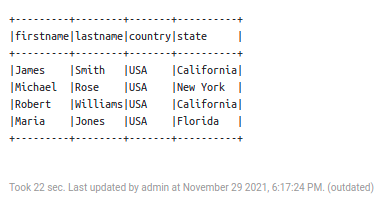

### PySpark Accumulator


In [ ]:
%pyspark

accum=spark.sparkContext.accumulator(0)
rdd=spark.sparkContext.parallelize([1,2,3,4,5])
rdd.foreach(lambda x:accum.add(x))
print(accum.value)

accuSum=spark.sparkContext.accumulator(0)
def countFun(x):
    global accuSum
    accuSum+=x
rdd.foreach(countFun)
print(accuSum.value)

accumCount=spark.sparkContext.accumulator(0)
rdd2=spark.sparkContext.parallelize([1,2,3,4,5])
rdd2.foreach(lambda x:accumCount.add(1))
print(accumCount.value)

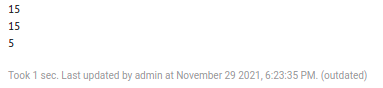

## 5 Лекция - RDD HOMEWORK<a class="anchor" id="uhw5"></a>

In [ ]:
# Сгруппировать по ключу, просуммировать значения, вывести результат

%pyspark

rdd = sc.parallelize([(1,2), (3,4), (3,6), (4,5), (3, 4), (1, 5), (4, 1)])


In [ ]:
# Word count

%pyspark

lines = sc.parallelize([
    "a ab abc",
    "a ac abc",
    "b b ab abc"
    ])

counts = lines.flatMap(lambda x: x.split(' ')) \
# дополнить код, чтобы получился rdd из пар (слово, частота)

output = counts.collect()

for (word, count) in output:
    print("%s: %i" % (word, count))

# HOMEWORKS

## 1 Лекция - Интро <a class="anchor" id="hw1"></a>

In [ ]:
%pyspark
import pyspark.sql.functions as f

# read data
events_df = spark.table("market.events")

# display data
events_df.show(100)


### Вывести топ категорий по количеству просмотров товаров за всё время


In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df \
    .where("event_type = 'view'") \
    .groupBy("category_code") \
    .agg(
        f.count("*").alias("total_views")
        ) \
    .orderBy(f.col("total_views").desc()) \
    .show(truncate=False)


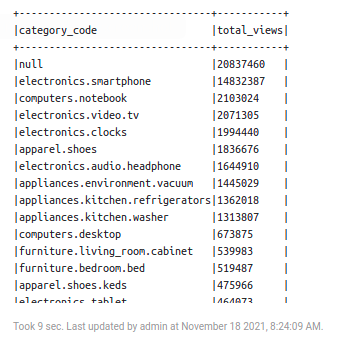

In [ ]:
%pyspark

events_df \
    .where("date == '2019-11-10'") \
    .where("event_type == 'purchase'") \
    .show(truncate=False)

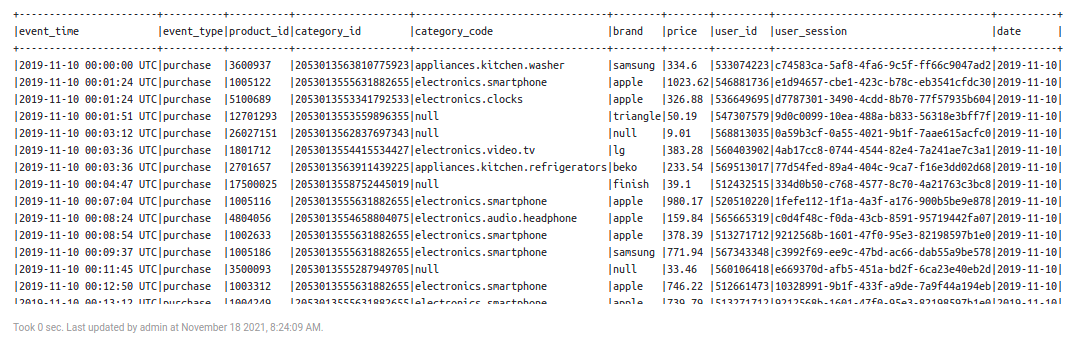

### Построить гистограмму распределения цен на проданные товары за 10 ноября 2019 года

In [ ]:
%pyspark
import pyspark.sql.functions as f

z.show(
    events_df \
    .where("date == '2019-11-10'") \
    .where("event_type == 'purchase'") \
    .withColumn("price_bins", f.expr("ceil(events.price/10) * 10")) \
        .groupBy("price_bins") \
        .agg(f.countDistinct("product_id").alias("products_amount"))  #.count()
)


# значение на графике - верхняя граница, т.е. 10 - это от 0 до 10 (не включительно), 50 - от 40 до 50 (не включительно и т.д)

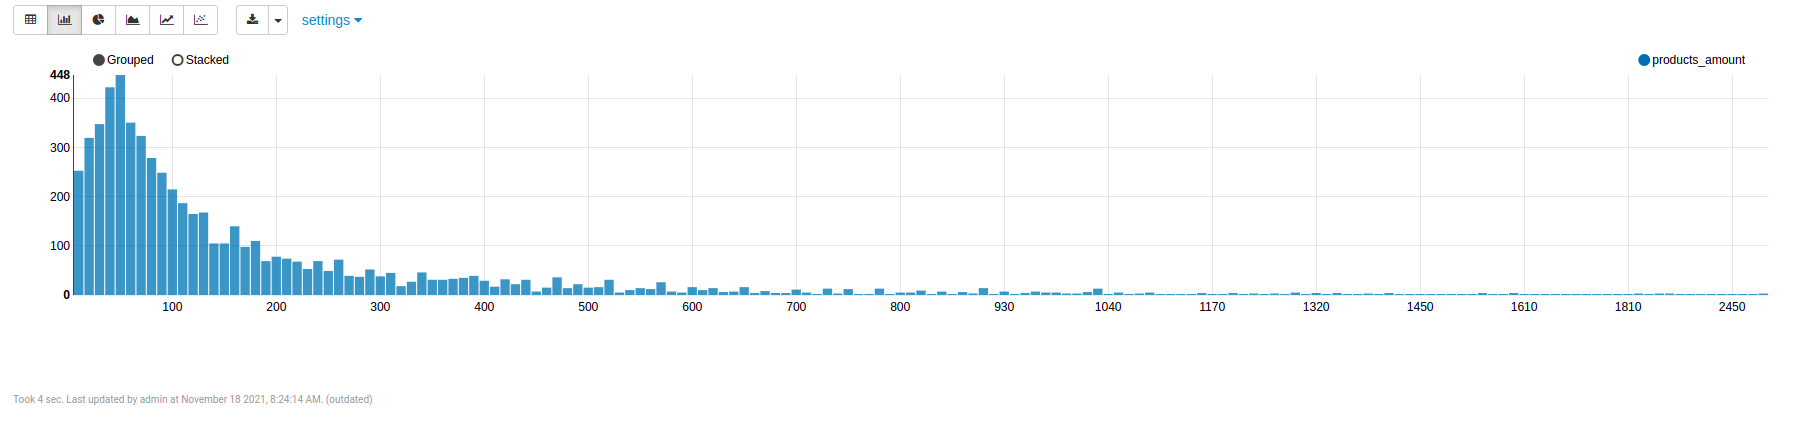

In [ ]:
%pyspark

# PROVERKA
events_df \
    .where("date == '2019-11-10'") \
    .where("event_type == 'purchase'") \
    .where("price >= 1330").where("price < 1340") \
    .agg(
        f.count("*").alias("total_rows")
        ) \
    .show()

# RAW DATA TEST

events_df \
    .where("date == '2019-11-10'") \
    .where("event_type == 'purchase'") \
    .where("price >= 1330").where("price < 1340") \
    .withColumn("price_bins_round", f.expr("round(events.price/10, 0) * 10")) \
    .withColumn("price_bins_ceil", f.expr("ceil(events.price/10) * 10")) \
    .show(truncate=False)
    
# раунд округляет по правилу HALF_UP что нам не подходит, поэтому берём ceil


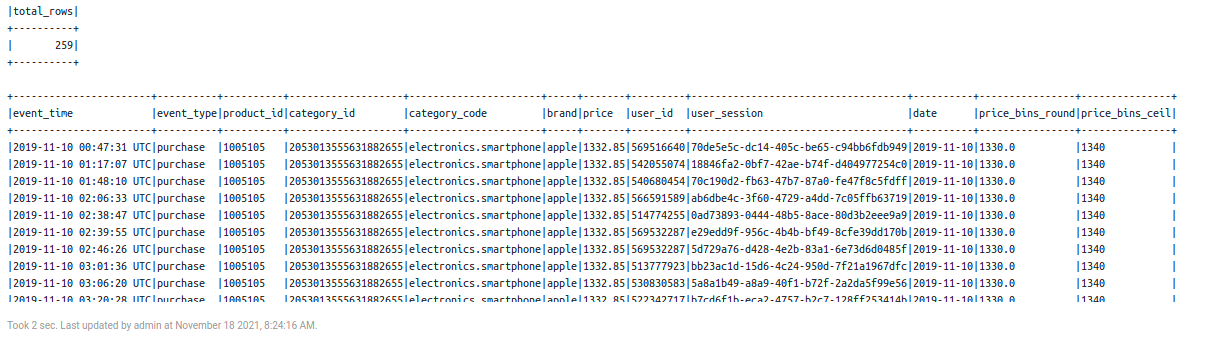

## 2 Лекция - DataFrame API 1 <a class="anchor" id="hw2"></a>

In [ ]:
%pyspark
import pyspark.sql.functions as f

events_df = spark.table("market.events")

events_df.show()

events_df.select('event_type').distinct().show()


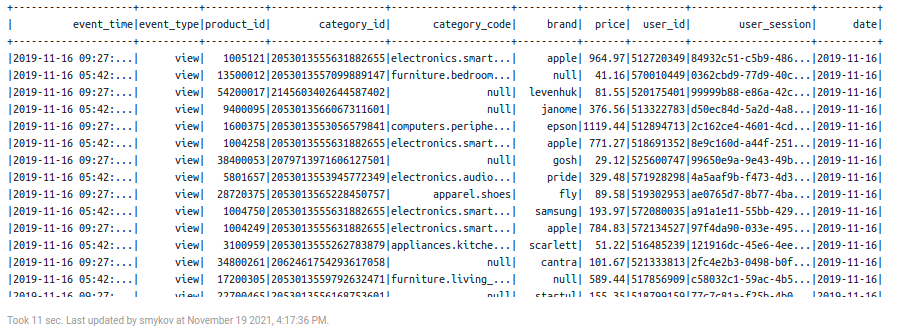

In [ ]:
%pyspark

events_df.printSchema()

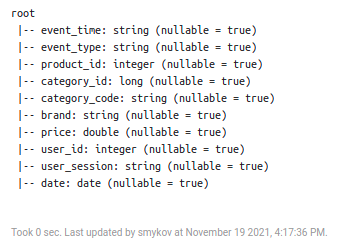

### Посчитать количество продаж отдельно бренда apple и остальных

In [ ]:
%pyspark
# pyspark.sql.functions.when @ CASE WHEN in SQL

df_apple = events_df\
                .where("event_type = 'purchase'")\
                .withColumn(
                            "brand", f.when(events_df["brand"] == "apple", "apple")
                            .otherwise("other")
                            )
                                 

df_apple\
    .groupBy("brand")\
    .agg(
        f.count("*").alias("total_sales")
        )\
    .show(truncate=False)



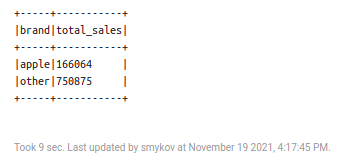

### Построить почасовой график продаж и прибыли за всё время

In [ ]:
%pyspark

# to_timestamp, date_trunc

df_sales = events_df\
                .where("event_type = 'purchase'")\
                .withColumn("dt", f.to_timestamp(f.col("event_time"), 'yyyy-MM-dd HH:mm:ss'))\
                .withColumn('hour', f.date_trunc(timestamp='dt', format='hour'))\
                .orderBy("hour")

z.show(
    df_sales\
        .groupBy("hour")\
        .agg(
                f.count("*").alias("purchases_per_hour")
            )
    )

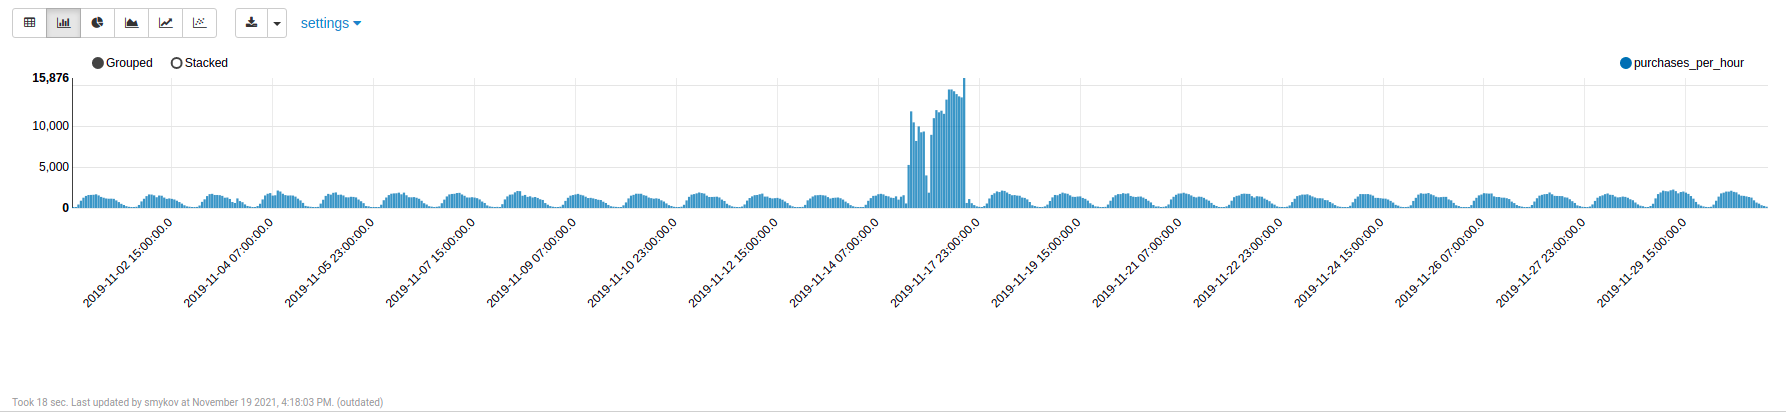

### Построить среднесуточный график продаж

In [ ]:
%pyspark

from pyspark.sql.types import IntegerType

hour = f.udf(lambda x: x.hour, IntegerType())

# to_timestamp, date_trunc, hour


z.show(
    df_sales\
        .withColumn('only_hour', hour("dt"))\
        .groupBy("only_hour")\
        .agg(
            f.count("*").alias("purchases_amount")
        )
)

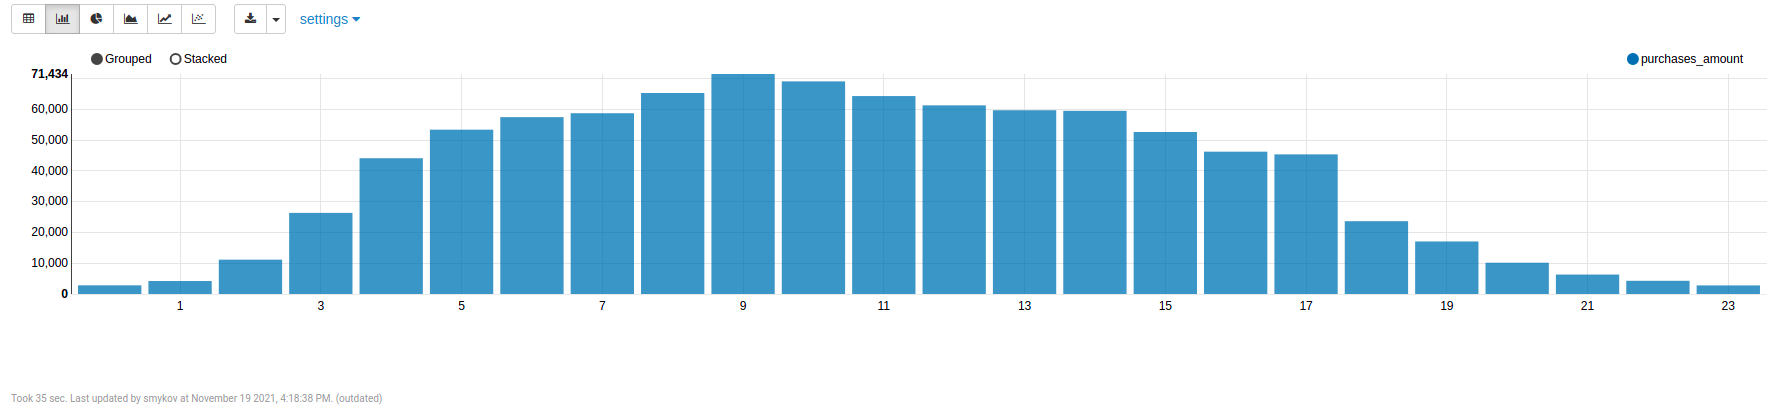

### Построить среднесуточный график продаж

In [ ]:
%pyspark

z.show(
    df_sales\
        .withColumn('only_hour', hour("dt"))\
        .groupBy("only_hour")\
        .agg(
            f.sum("price").alias("hourly_income")
        )
)

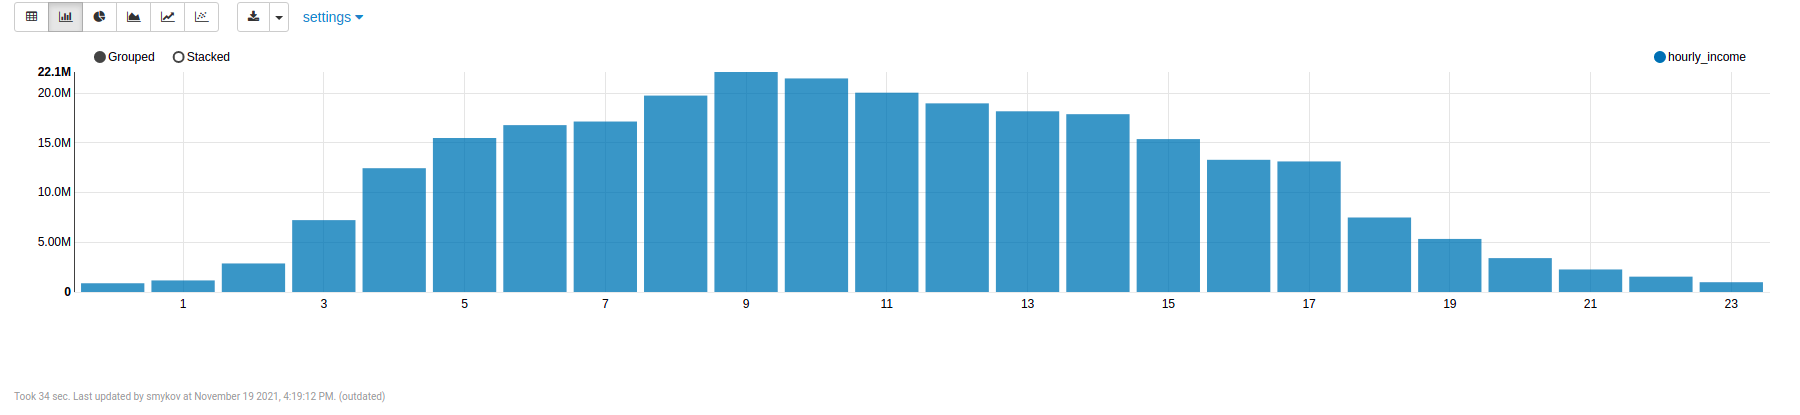

## 3 Лекция - DataFrame API 2 <a class="anchor" id="hw3"></a>

In [ ]:
%pyspark

import pyspark.sql.functions as f
from pyspark.sql.functions import udf, col, lag, lead
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType


print("https://arena-hadoop.inno.tech:18088/proxy/" + sc.applicationId)

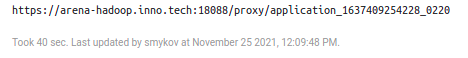

In [ ]:
%pyspark

events_df = spark.table("market.events").where("date < '2019-11-02'")

events_df.show()

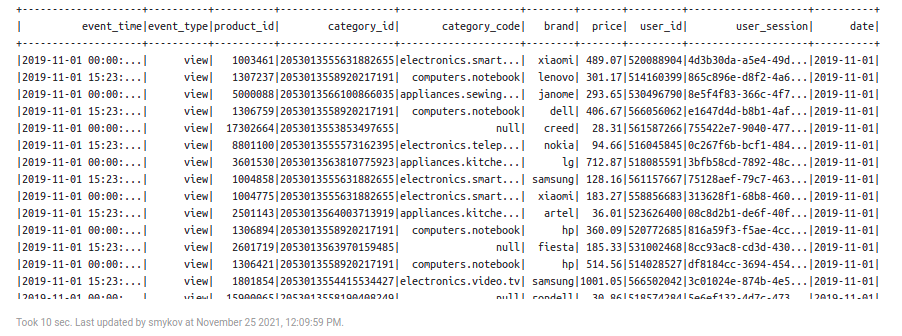

### Добавить колонки category_1, category_2, category_3 с категориями различного уровня

In [ ]:
%pyspark

def split_str(s, pos):
    if s is None:
        return None
        
    try:
        return s.split('.')[pos]
    except:
        return None

split_strUdf = udf(split_str)    

df_cat = events_df\
.select(events_df.columns)\
.withColumn("cat_1", split_strUdf(col("category_code"), f.lit(0)))\
.withColumn("cat_2", split_strUdf(col("category_code"), f.lit(1)))\
.withColumn("cat_3", split_strUdf(col("category_code"), f.lit(2)))


df_cat.show()


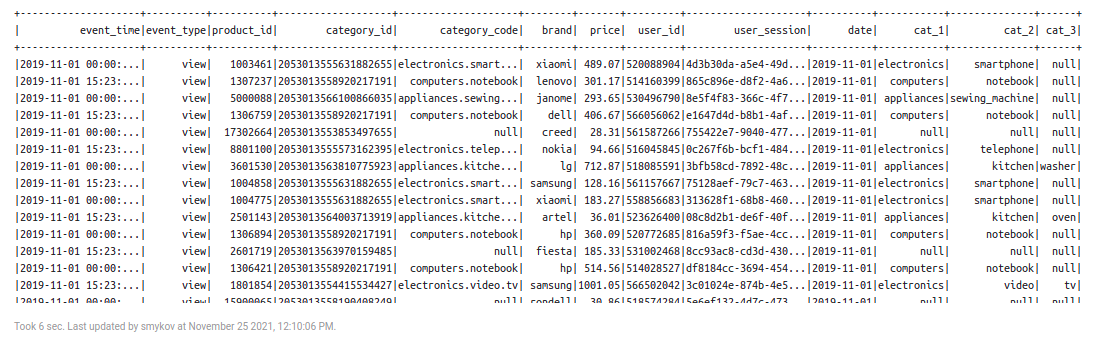

### Вывести топ-3 брендов по количеству просмотров для каждой категории 2-го уровня

In [ ]:
%pyspark

windowSpec = Window.partitionBy("cat_2").orderBy(col("views_amount").desc())


df_cat\
.where(col("brand").isNotNull())\
.where("event_type = 'view'")\
.groupBy("cat_2", "brand")\
.agg(
    f.count("product_id").alias("views_amount")
    )\
.withColumn("rank", f.row_number().over(windowSpec))\
.where("rank < 4")\
.orderBy("cat_2", col("views_amount").desc())\
.show(truncate=False)

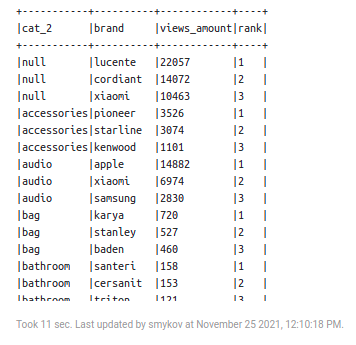

### создание hw_3.tracks для запуска локально (на кластере уже готова)

In [ ]:
%pyspark

import pyspark.sql.functions as f
from pyspark.sql.types import *

sch=ArrayType(StringType());

# скачать датасет: http://37.139.43.86/tracks 

# важно что разделитель ', ' с пробелом, иначе пробелы добавятся в значения
tracks = spark.read.option("header", "true") \
        .option("escape", '"') \
        .option("InferSchema", "true") \
        .csv("data/tracks.csv") \
        .withColumn("release_year", f.substring("release_date", 1, 4).cast(IntegerType())) \
        .withColumn("array_artist", f.split(f.regexp_replace(f.col("artists"), "[\]\[\']", ""),", ")) \
        .cache() #выделяем год в отдельную колонку и преобразуем колонку с артистами в массив

tracks_exp = tracks.select(  
                            "name", 
                            "popularity",
                            "danceability",
                            "energy",
                            "speechiness",
                            "acousticness",
                            "liveness",
                            "valence",
                            "release_year",
                            "artists",
                            f.explode(f.col("array_artist") ).alias("name_artist")
                        ) #создаем отдельную таблицу с развернутым массивом артистов
                        
tracks_exp.printSchema()

spark.sql("create database hw_3")
tracks_exp.write.mode("overwrite").saveAsTable("hw_3.tracks")

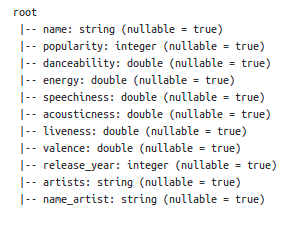

In [ ]:
%pyspark

tracks = spark.table("hw_3.tracks")
tracks.show()

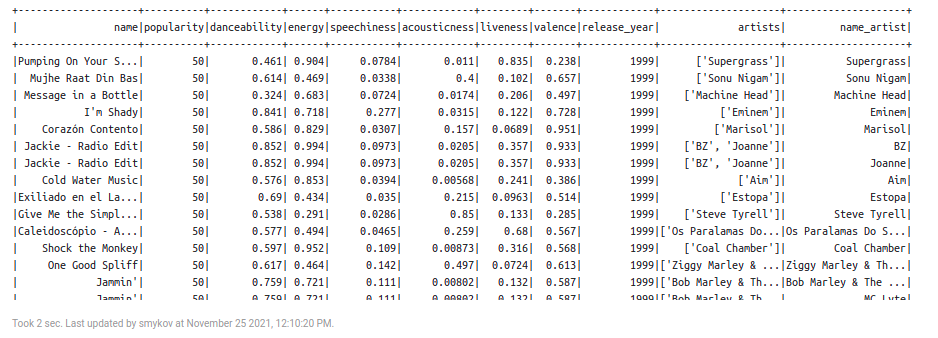

In [ ]:
%pyspark

windowSpecTracks = Window.partitionBy("release_year").orderBy(col("popularity").desc(), "name")

df_tracks = tracks\
.where(col("name").isNotNull())\
.withColumn("year_rank", f.dense_rank().over(windowSpecTracks))\
.orderBy("release_year", "year_rank")\
.where("year_rank <= 100")

df_tracks.where("release_year = 2020").show(truncate=False)

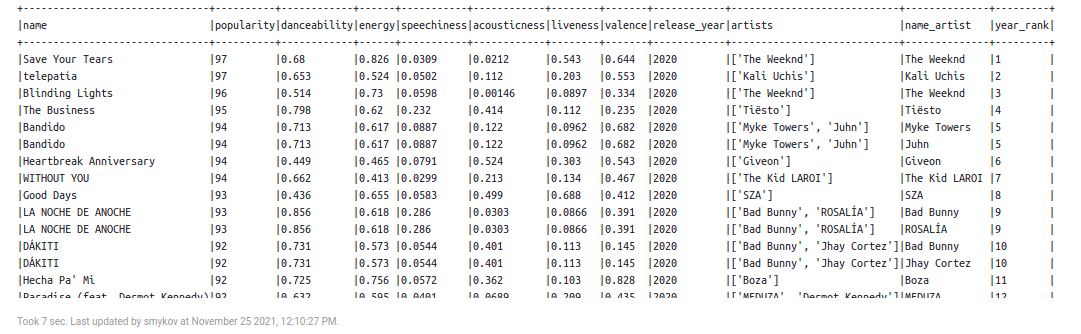

### 2.1. Какие артисты выпустили наибольшее число песен из годовых топ-100 (по популярности)?

In [ ]:
%pyspark

df_tracks\
    .groupBy("name_artist")\
    .agg(
        f.count("name").alias("tracks_amount")
        )\
    .orderBy("tracks_amount", ascending=False)\
    .show(truncate=False)

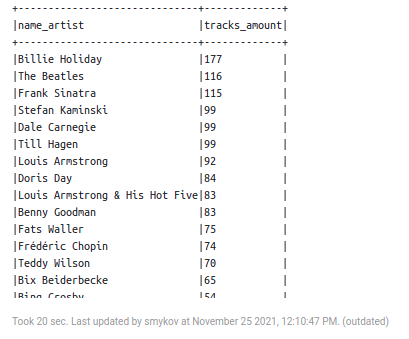

### 2.2. Вывести топ артистов, которые чаще других попадали в годовой топ-100 песен по популярности?

In [ ]:
%pyspark

df_tracks\
.groupBy("name_artist")\
.agg(
    f.countDistinct(col("release_year")).alias("count_artist")
    )\
.orderBy("count_artist", ascending=False)\
.show(truncate=False)

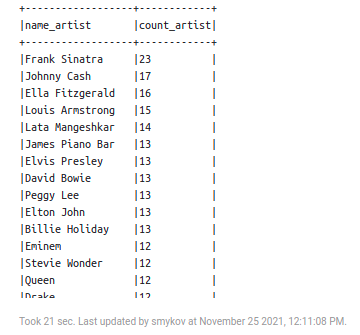

In [ ]:
%pyspark

df_artists = df_tracks\
.select("name_artist", "release_year")\
.dropDuplicates()\
.orderBy("release_year")


windowSpecArtists = Window.partitionBy("name_artist").orderBy("release_year")
windowSpecArtistsStep = Window.partitionBy("name_artist").orderBy("step")

windowSpecGrp = Window.partitionBy("name_artist").orderBy("release_year")
windowSpecMxYrs = Window.partitionBy("grp", "name_artist").orderBy("release_year")

# https://stackoverflow.com/questions/56384625/pyspark-cumulative-sum-with-reset-condition

#x.withColumn("grp", f.sum((f.col("C") == 0).cast("int")).over(Window.orderBy("A"))
#).withColumn("D", f.sum(f.col("C")).over(Window.partitionBy("grp").orderBy("A"))
#).drop("grp")


#def clean_step(i):
#    if i is None:
#        return 0
        
#    return 1 if i == 1 else 0

#clean_stepUdf = udf(clean_step)   
#.withColumn("step_clean", clean_stepUdf(col("step")))\


df_artists\
.where("name_artist = 'Drake' or name_artist = 'The Beatles'")\
.withColumn("lag", lag("release_year", 1).over(windowSpecArtists))\
.withColumn("step", col("release_year") - col("lag"))\
.withColumn(
            "step_clean", f.when(col("step") == 1, 1)
                            .otherwise(0)
            )\
.withColumn("grp", f.sum((f.col("step_clean") == 0).cast("int")).over(windowSpecGrp))\
.withColumn("D", f.sum(f.col("step_clean")).over(windowSpecMxYrs))\
.show(40, False)



df_artists_clean = df_artists\
.withColumn("lag", lag("release_year", 1).over(windowSpecArtists))\
.withColumn("step", col("release_year") - col("lag"))\
.withColumn(
            "step_clean", f.when(col("step") == 1, 1)
                            .otherwise(0)
            )\
.withColumn("grp", f.sum((f.col("step_clean") == 0).cast("int")).over(windowSpecGrp))\
.withColumn("D", f.sum(f.col("step_clean")).over(windowSpecMxYrs))

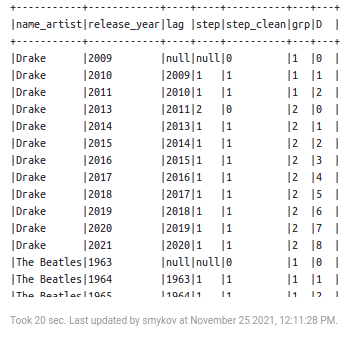

### *2.3. Какие артисты дольше других несколько лет подряд держались в ежегодном топ-100 песен по популярности?

In [ ]:
%pyspark

df_artists_clean\
.groupBy("name_artist")\
.agg(
    f.max("D").alias("max_years")
    )\
.withColumn("max_years_clean", (col("max_years") + 1).cast(IntegerType()))\
.drop("max_years")\
.orderBy("max_years_clean", ascending=False)\
.show(truncate=False)


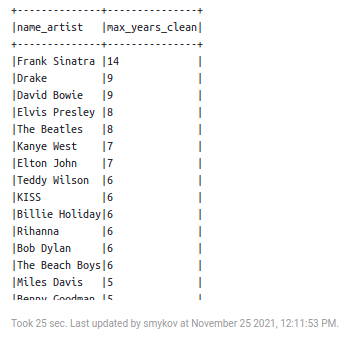

In [ ]:
%pyspark

df_metrics = tracks\
.groupBy("name_artist")\
.agg(
    f.avg("danceability").alias("mean_danceability"),
    f.avg("energy").alias("mean_energy"),
    f.avg("speechiness").alias("mean_speechiness"),
    f.avg("acousticness").alias("mean_acousticness"),   
    f.avg("liveness").alias("mean_liveness"),
    f.avg("valence").alias("mean_valence")
    )


df_metrics.show()

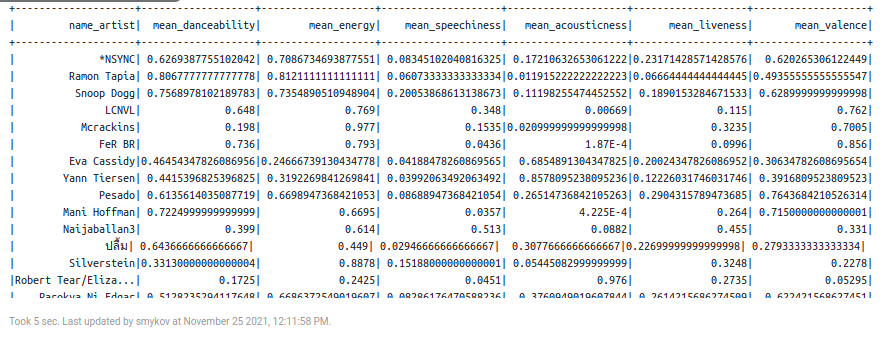

In [ ]:
%pyspark

df_metrics.orderBy("mean_danceability", ascending=False).select("name_artist", "mean_danceability").show(3)
df_metrics.orderBy("mean_energy", ascending=False).select("name_artist", "mean_energy").show(3)
df_metrics.orderBy("mean_speechiness", ascending=False).select("name_artist", "mean_speechiness").show(3)
df_metrics.orderBy("mean_acousticness", ascending=False).select("name_artist", "mean_acousticness").show(3)
df_metrics.orderBy("mean_liveness", ascending=False).select("name_artist", "mean_liveness").show(3)
df_metrics.orderBy("mean_valence", ascending=False).select("name_artist", "mean_valence").show(3)

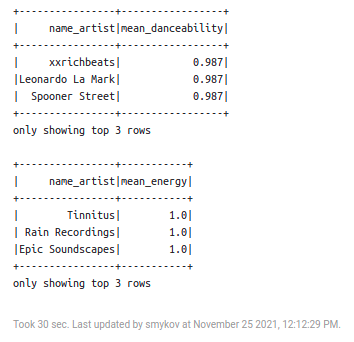

In [ ]:
%pyspark

df_tracks_mean = tracks\
.groupBy("release_year")\
.agg(
    f.avg("danceability").alias("mean_danceability"),
    f.avg("energy").alias("mean_energy"),
    f.avg("speechiness").alias("mean_speechiness"),
    f.avg("acousticness").alias("mean_acousticness"),   
    f.avg("liveness").alias("mean_liveness"),
    f.avg("valence").alias("mean_valence")
    )
    
df_merged = tracks\
.join(df_tracks_mean, ["release_year"])\
.withColumn("norm_danceability", col("danceability") / col("mean_danceability"))\
.withColumn("norm_energy", col("energy") / col("mean_energy"))\
.withColumn("norm_speechiness", col("speechiness") / col("mean_speechiness"))\
.withColumn("norm_acousticness", col("acousticness") / col("mean_acousticness"))\
.withColumn("norm_liveness", col("liveness") / col("mean_liveness"))\
.withColumn("norm_valence", col("valence") / col("mean_valence"))\
.select(
    "name_artist",
    "norm_danceability",
    "norm_energy",
    "norm_speechiness", 
    "norm_acousticness", 
    "norm_liveness",
    "norm_valence"
    )\
.groupBy("name_artist")\
.agg(
    f.round(f.avg("norm_danceability"), 2).alias("mean_norm_danceability"),
    f.round(f.avg("norm_energy"), 2).alias("mean_norm_energy"),
    f.round(f.avg("norm_speechiness"), 2).alias("mean_norm_speechiness"),
    f.round(f.avg("norm_acousticness"), 2).alias("mean_norm_acousticness"),   
    f.round(f.avg("norm_liveness"), 2).alias("mean_norm_liveness"),
    f.round(f.avg("norm_valence"), 2).alias("mean_norm_valence")
    )

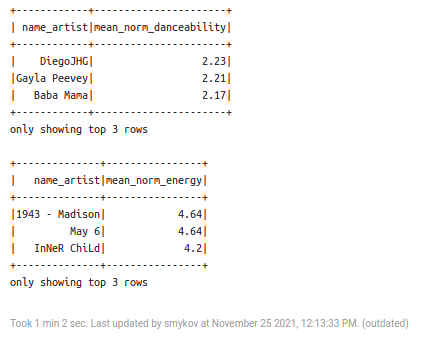

In [ ]:
%pyspark

cols = ['mean_norm_danceability', 'mean_norm_energy', 'mean_norm_speechiness', 'mean_norm_acousticness', 'mean_norm_liveness', 'mean_norm_valence']

for col in cols:
    df_merged.orderBy(col, ascending=False).select("name_artist", col).show(3)

In [ ]:
%pyspark

df_merged.orderBy("mean_norm_danceability", ascending=False).select("name_artist", "mean_norm_danceability").show(3)
df_merged.orderBy("mean_norm_energy", ascending=False).select("name_artist", "mean_norm_energy").show(3)
df_merged.orderBy("mean_norm_speechiness", ascending=False).select("name_artist", "mean_norm_speechiness").show(3)
df_merged.orderBy("mean_norm_acousticness", ascending=False).select("name_artist", "mean_norm_acousticness").show(3)
df_merged.orderBy("mean_norm_liveness", ascending=False).select("name_artist", "mean_norm_liveness").show(3)
df_merged.orderBy("mean_norm_valence", ascending=False).select("name_artist", "mean_norm_valence").show(3)

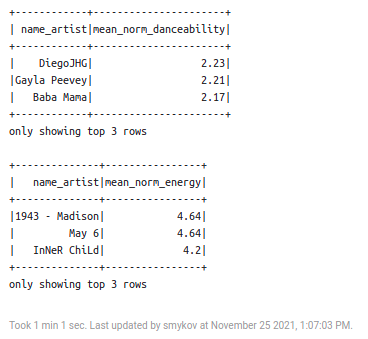

## 4 Лекция - Оптимизация запросов <a class="anchor" id="hw4"></a>

In [ ]:
%pyspark

# imports

from pyspark.sql.functions import broadcast
from pyspark.sql.functions import col

import pyspark.sql.functions as f

In [ ]:
%spark.conf

spark.executor.instances=2


### Задание 1

Для упражнений сгрененирован большой набор синтетических данных в таблице hw2.events_full. Из этого набора данных созданы маленькие (относительно исходного набора) таблицы разного размера kotelnikov.sample_[small, big, very_big].

Ответить на вопросы:

- какова структура таблиц
- сколько в них записей
- сколько места занимают данные

In [ ]:
%pyspark

spark.table("hw_4.sample_small").printSchema()
spark.table("hw_4.sample_big").printSchema()
spark.table("hw_4.sample_very_big").printSchema()

# таблицы содержат только 1 колонку - event_id

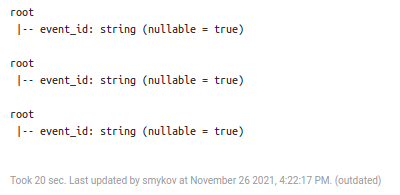

In [ ]:
%pyspark

small = spark.table("hw_4.sample_small").count()
big = spark.table("hw_4.sample_big").count()
very_big = spark.table("hw_4.sample_very_big").count()

print("sample_small содержит {} строк".format(small))
print("sample_big содержит {} строк".format(big))
print("sample_very_big содержит {} строк".format(very_big))

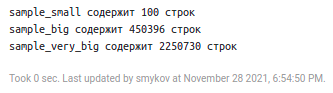

In [ ]:
%sh

hdfs dfs -ls -h /apps/hive/warehouse/hw_4.db/
hdfs dfs -du -h /apps/hive/warehouse/hw_4.db/

# size  |  disk_space_consumed_with_all_replicas  |  full_path_name

# small    - 7.1 K
# big      - 27.4 M
# very big - 136.7 M


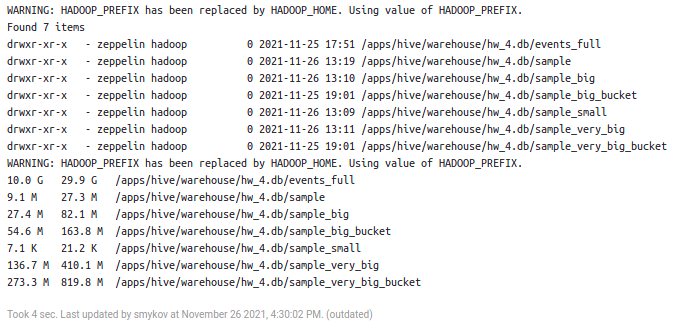

### Задание 2


Получить планы запросов для джойна большой таблицы hw2.events_full с каждой из таблиц hw2.sample, hw2.sample_big, hw2.sample_very_big по полю event_id. В каких случаях используется BroadcastHashJoin?

BroadcastHashJoin автоматически выполняется для джойна с таблицами, размером меньше параметра spark.sql.autoBroadcastJoinThreshold. Узнать его значение можно командой spark.conf.get(“spark.sql.autoBroadcastJoinThreshold”).

In [ ]:
%pyspark

print("autoBroadcastJoinThreshold = {} MB".format( int(spark.conf.get("spark.sql.autoBroadcastJoinThreshold")) / 1024 / 1024))
print('-----------------------------------------')

small_join = spark.table("hw_4.events_full").join(spark.table("hw_4.sample_small"), 'event_id').explain()
print('-----------------------------------------')

big_join = spark.table("hw_4.events_full").join(spark.table("hw_4.sample_big"), 'event_id').explain()
print('-----------------------------------------')

very_big_join = spark.table("hw_4.events_full").join(spark.table("hw_4.sample_very_big"), 'event_id').explain()


# small_join - BroadcastHashJoin
# big_join - SortMergeJoin
# very_big_join - SortMergeJoin


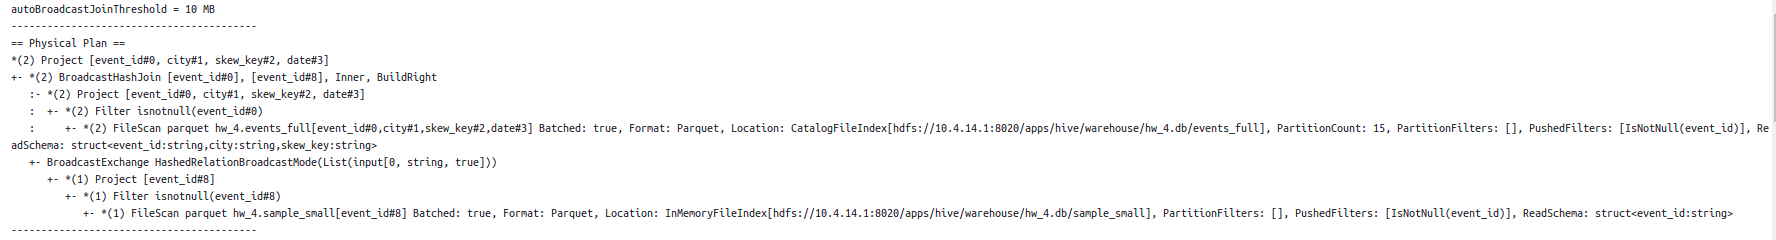

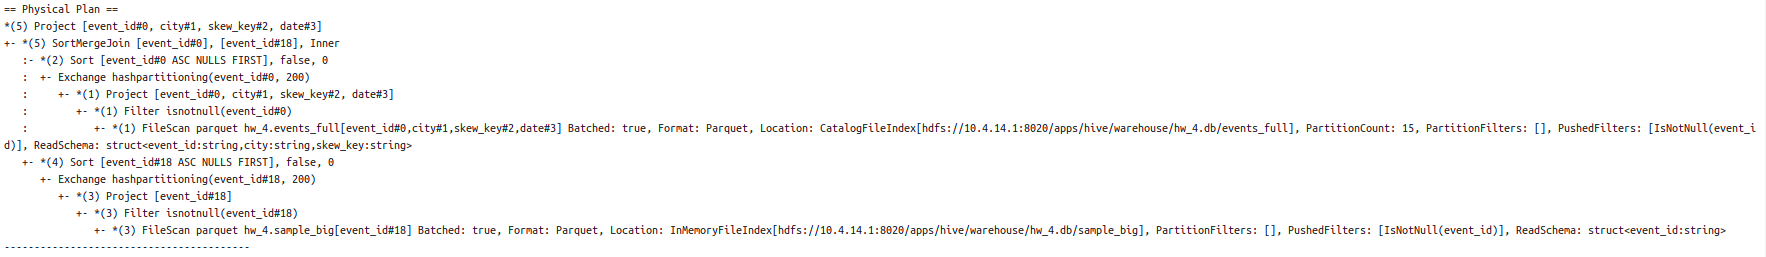

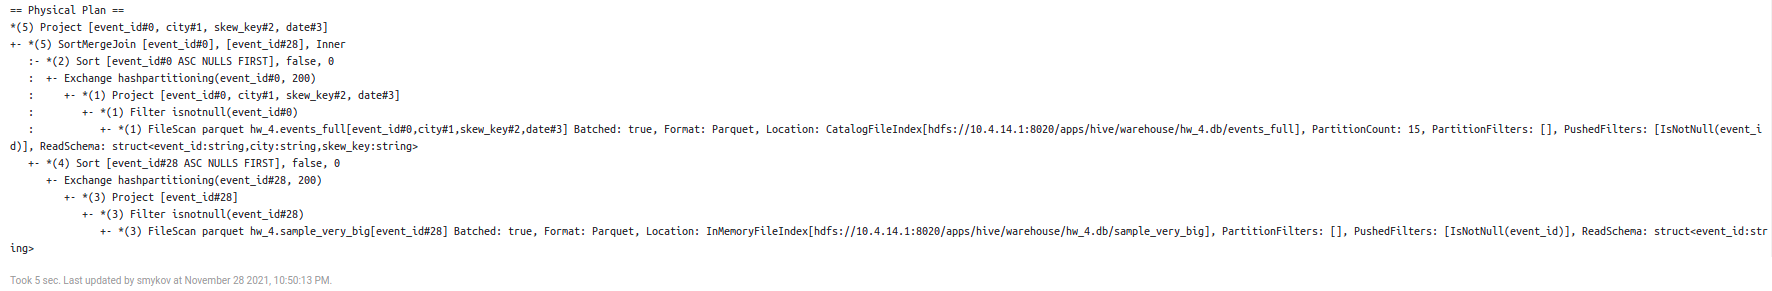

### Задание 3


Выполнить джойны с таблицами hw2.sample, hw2.sample_big в отдельных параграфах, чтобы узнать время выполнения запросов (например, вызвать .count() для результатов запросов). Время выполнения параграфа считается автоматически и указывается в нижней части по завершении

Зайти в spark ui (ссылку сгенерировать в следующем папраграфе). Сколько tasks создано на каждую операцию? Почему именно столько? Каков DAG вычислений?

In [ ]:
%pyspark
spark.table("hw_4.events_full").join(spark.table("hw_4.sample_small"), 'event_id').count()



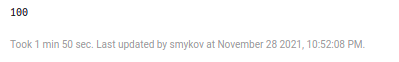

In [ ]:
%python

# tasks (for all stages) - 82
# stages                 - 2

### STAGE 1
# submitted              - 2021/11/28 19:15:33
# tasks                  - 81
# duration               - 2.4 min
# input                  - 8.9 GB
# shuffle write          - 4.4 KB


### STAGE 2
# submitted              - 2021/11/28 19:17:55
# tasks                  - 1
# duration               - 85 ms
# shuffle read           - 4.4 KB


# resulting count        - 100


### DAG

### STAGE 1
# WholeStageCodegen: FileScanRDD -> MapPartitionsRDD
# Exchange:  MapPartitionsRDD

### STAGE 2
# Exchange: ShuffledRowRDD
# WholeStageCodegen: MapPartitionsRDD
# mapPartitionsInternal: MapPartitionsRDD

In [ ]:
%pyspark
spark.table("hw_4.events_full").join(spark.table("hw_4.sample_big"), 'event_id').count()

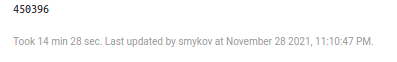

In [ ]:
%python

# tasks (for all stages) - 284
# stages                 - 4

### STAGE 1
# submitted              - 2021/11/28 18:58:43
# tasks                  - 81
# duration               - 11 min 
# input                  - 8.9 GB
# shuffle write          - 4.4 KB


### STAGE 2
# submitted              - 2021/11/28 19:09:35
# tasks                  - 200
# duration               - 5.6 min
# shuffle read           - 9.0 GB
# shuffle write          - 11.5 KB

### STAGE 3
# submitted              - 2021/11/28 19:15:11
# tasks                  - 1
# duration               - 56 ms
# shuffle read           - 11.5 KB

### STAGE 4
# submitted              - 2021/11/28 19:15:16
# tasks                  - 1
# duration               - 66 ms
# input                  - 7.1 KB


# resulting count        - 450396


### DAG

### STAGE 1
# WholeStageCodegen: FileScanRDD -> MapPartitionsRDD
# Exchange:  MapPartitionsRDD

### STAGE 2
# Exchange: ShuffledRowRDD
# WholeStageCodegen: MapPartitionsRDD
# mapPartitionsInternal: MapPartitionsRDD

# Остальные не посмотрел потому что джоба исполняется почти 20 минут, на момент ожидания ДАГ не сформирован, 
# а далее у меня спарк падал каждые 10 минут, ждал несколько раз по 20 минут, но..

### Насильный broadcast

Оптимизировать джойн с таблицами hw2.sample_big, hw2.sample_very_big с помощью broadcast(df). Выполнить запрос, посмотреть в UI, как поменялся план запроса, DAG, количество тасков. Второй запрос не выполнится

In [ ]:
%pyspark

spark.table("hw_4.events_full")\
.join(broadcast(spark.table("hw_4.sample_big")), "event_id").count()

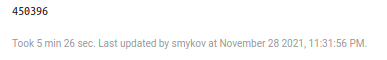

In [ ]:
%python

# tasks (for all stages) - 84
# stages                 - 3

### STAGE 1
# submitted              - 2021/11/28 23:26:37
# tasks                  - 2
# duration               - 9 s
# input                  - 27.4 MB


### STAGE 2
# submitted              - 2021/11/28 23:26:48
# tasks                  - 81
# duration               - 5.1 min
# input                  - 8.9 GB
# shuffle write          - 4.7 KB

### STAGE 3
# submitted              - 2021/11/28 23:31:56
# tasks                  - 0.1 s
# duration               - 56 ms
# shuffle read           - 4.7 KB


# resulting count        - 450396


### DAG

### Спарк падает сразу после выполнения запроса, ДАГ не успеваю посмотреть

In [ ]:
%pyspark

# Верю на слово что запрос не выполниться (хотя в лекции выполнялся)

# spark.table("hw_4.events_full")\
# .join(broadcast(spark.table("hw_4.sample_very_big")), "event_id")

### Отключение auto broadcast

Отключить автоматический броадкаст командой spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1"). Сделать джойн с семплом hw_4.sample, сравнить время выполнения запроса.

In [ ]:
%pyspark
### turn off autobroadcast
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")


spark.table("hw_4.events_full")\
.join(spark.table("hw_4.sample"), "event_id").count()


# reset autobroadcast to default
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "26214400")

In [ ]:
%pyspark
### turn off autobroadcast
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")


spark.table("hw_4.events_full")\
.join(spark.table("hw_4.sample"), "event_id").explain()


# reset autobroadcast to default
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "26214400")

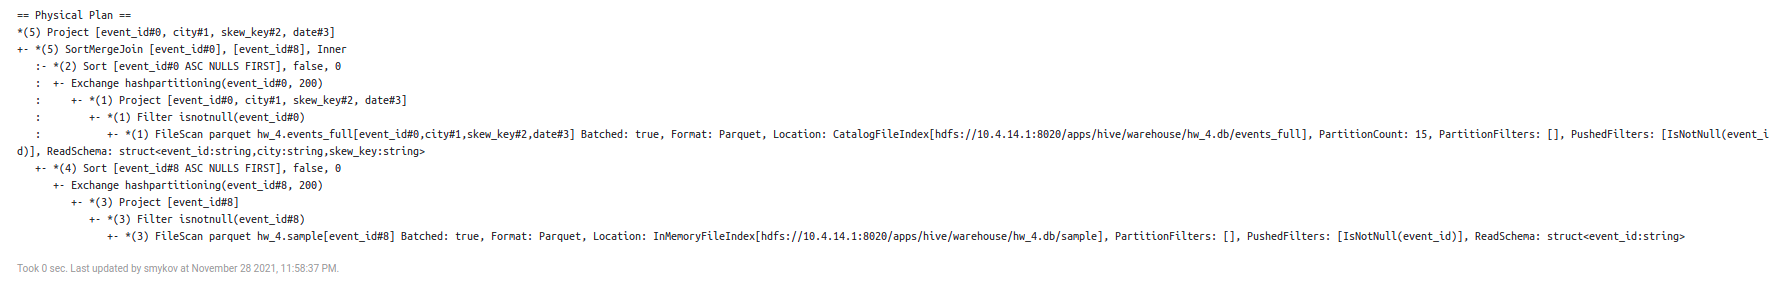

In [ ]:
%python

"""
Главное что стоит отметить - при оптимизации соединения с помощью broadcast мы получаем всего 3 stage (а не 4 как при отлкюченном), а так же
время выполнения запроса сильно уменьшается:

~ 5 минут с оптимизацией
> 20 минут (20,5 + нескольколько миллисекунд) без оптимизации + соединение неоптимальным запросом (SortMergeJoin вместо BroadcastHashJoin)


"""

### Задание 4
.
.
.

В процессе обработки данных может возникнуть перекос объёма партиций по количеству данных (data skew). В таком случае время выполнения запроса может существенно увеличиться, так как данные распределятся по исполнителям неравномерно. В следующем параграфе происходит инициализация датафрейма, этот параграф нужно выполнить, изменять код нельзя. В задании нужно работать с инициализированным датафреймом.

Датафрейм разделен на 30 партиций по ключу city, который имеет сильно неравномерное распределение.

In [ ]:
# нужно выполнить, изменять код нельзя

%pyspark 

skew_df = spark.table("hw_4.events_full")\
.where("date = '2020-11-01'")\
.repartition(30, col("city"))\
.cache()

skew_df.count()

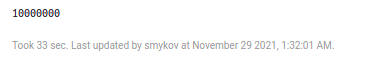

### 4.1. Наблюдение проблемы

Посчитать количество event_count различных событий event_id , содержащихся в skew_df с группировкой по городам. Результат упорядочить по event_count.

В spark ui в разделе jobs выбрать последнюю, в ней зайти в stage, состоящую из 30 тасков (из такого количества партиций состоит skew_df). На странице стейджа нажать кнопку Event Timeline и увидеть время выполнения тасков по экзекьюторам. Одному из них выпала партиция с существенно большим количеством данных. Остальные экзекьюторы в это время бездействуют -- это и является проблемой, которую предлагается решить далее.

In [ ]:
%pyspark

skew_df.printSchema()

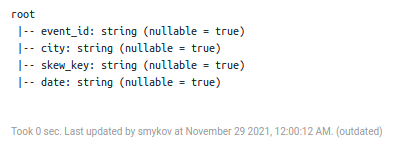

In [ ]:
%pyspark

skew_df\
.groupBy(col("city"))\
.agg(
    f.count(col("event_id")).alias("event_count")
   )\
.orderBy("event_count", ascending=False)\
.show(truncate=False)


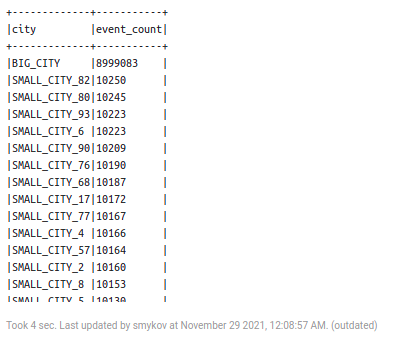

In [ ]:
%python

"""
Проблема видна невооруженным глазом (значение Max):


Summary Metrics for 30 Completed Tasks
Metric	    Min	     25th percentile	Median	         75th percentile	Max
Duration	8 ms	 19 ms	            23 ms	         32 ms	            2 s
GC Time	    0 ms	 0 ms	            0 ms	         0 ms               82 ms
Input Size / Records	0.0 B / 0	2.7 MB / 3	4.0 MB / 4	6.5 MB / 5	587.9 MB / 902
"""

### 4.2. repartition

один из способов решения проблемы агрегации по неравномерно распределенному ключу является предварительное перемешивание данных. Его можно сделать с помощью метода repartition(p_num), где p_num -- количество партиций, на которые будет перемешан исходный датафрейм

In [ ]:
%pyspark


balanced_df = skew_df.repartition(10)

print(balanced_df.rdd.getNumPartitions())



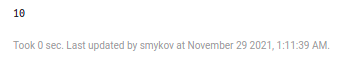

### 4.3. Key Salting

Другой способ исправить неравномерность по ключу -- создание синтетического ключа с равномерным распределением. В нашем случае неравномерность исходит от единственного значения city='BIG_CITY', которое часто повторяется в данных и при группировке попадает к одному экзекьютору. В таком случае лучше провести группировку в два этапа по синтетическому ключу CITY_SALT, который принимает значение BIG_CITY_rand (rand -- случайное целое число) для популярного значения BIG_CITY и CITY для остальных значений. На втором этапе восстанавливаем значения CITY и проводим повторную агрегацию, которая не занимает времени, потому что проводится по существенно меньшего размера данным. 

Такая же техника применима и к джойнам по неравномерному ключу, см, например https://itnext.io/handling-data-skew-in-apache-spark-9f56343e58e8

Что нужно реализовать:
- добавить синтетический ключ
- группировка по синтетическому ключу
- восстановление исходного значения
- группировка по исходной колонке

In [ ]:


df_salt = skew_df\
.withColumn(
            "city_salt", f.when(
                                col("city") == "BIG_CITY", 
                                f.concat(
                                         col("city"), f.lit("_"), f.lit(f.round(f.rand(100) * 100, 0))
                                        )
                               )
                          .otherwise(col("city"))
            )

df_salt.where(col('city').like("%BIG_CITY%")).show()


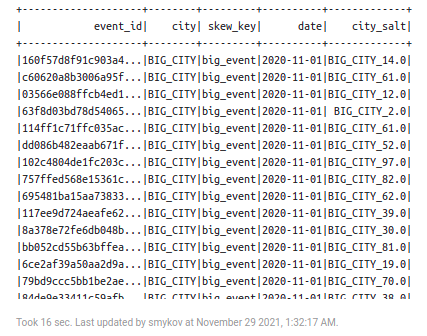

In [ ]:
%pyspark

df_salt = skew_df\
.withColumn(
            "city_salt", f.when(
                                col("city") == "BIG_CITY", 
                                f.concat(
                                         col("city"), f.lit("_"), f.lit(f.round(f.rand(100) * 100, 0))
                                        )
                               )
                          .otherwise(col("city"))
            )\
.groupBy(col("city_salt"))\
.agg(
    f.count(col("event_id")).alias("event_count")
   )\
.withColumn(
            "city_clean", f.when(
                           col('city_salt').like("BIG%"), "BIG_CITY"
                           #col('city_salt').startsWith("BIG_CITY"), "BIG_CITY"
                          )
                           .otherwise(col("city_salt"))
           )\
.groupBy(col("city_clean"))\
.agg(
    f.sum(col("event_count")).alias("event_count")
   )\
.orderBy("event_count", ascending=False)\
.show(truncate=False)

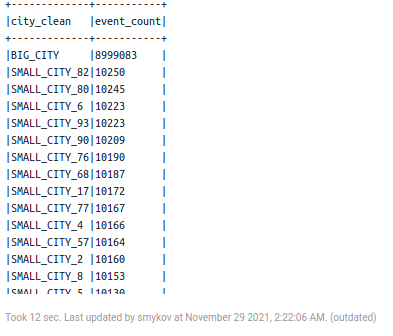

## 5 Лекция - RDD <a class="anchor" id="hw5"></a>

### Сгруппировать по ключу, просуммировать значения, вывести результат

In [ ]:
%pyspark

rdd = sc.parallelize([(1,2), (3,4), (3,6), (4,5), (3, 4), (1, 5), (4, 1)])


In [ ]:
%pyspark

rdd.groupByKey().map(lambda x:(x[0], sum(x[1])) ).collect()

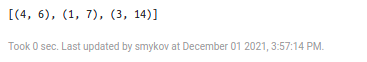

### Word count

In [ ]:
%pyspark

lines = sc.parallelize([
    "a ab abc",
    "a ac abc",
    "b b ab abc"
    ])

counts = lines.flatMap(lambda x: x.split(" "))\
.map(lambda word : (word, 1))\
.groupByKey().map(lambda x:(x[0], sum(x[1])))

output = counts.collect()

for (word, count) in output:
    print("%s: %i" % (word, count))

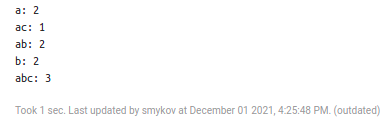